In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,  GroupShuffleSplit
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

data = pd.read_csv('/work/JinStorage/Hyponatremia/MIMIC_4/filtered_data.csv')

In [2]:
data = data.drop('waiting_time', axis=1)

In [3]:
data.head()

subject_id   hadm_id     sodium_charttime  Sodium  Potassium  Chloride  \
0    10014354  26486158  2148-08-23 09:13:00   130.0        4.4      91.0   
1    10014354  26486158  2148-08-23 17:00:00   130.0        4.4      90.0   
2    10014354  26486158  2148-08-24 00:00:00   126.0        4.4      88.0   
3    10014354  26486158  2148-08-24 08:04:00   125.0        4.6      85.0   
4    10014354  26486158  2148-08-24 13:07:00   120.0        4.6      85.0   

   Creatinine  Urea Nitrogen  Bicarbonate  Anion Gap  ...   sw  furosemide  \
0         0.9            9.0         25.0       14.0  ...  0.0        80.0   
1         0.9           10.0         25.0       15.0  ...  0.0        80.0   
2         0.9           10.0         25.0       13.0  ...  0.0        80.0   
3         1.0           15.0         23.0       17.0  ...  0.0        80.0   
4         1.0           15.0         23.0       17.0  ...  0.0        80.0   

   vial  desmopressin nasal  BMI (kg/m2)  age  gender  Weight (kg)  \
0   0.0                 0.0    36.698936   60       1   123.317245   
1   0.0                 0.0    36.698936   60       1   123.317245   
2   0.0                 0.0    36.698936   60       1   123.317245   
3   0.0                 0.0    36.698936   60       1   123.317245   
4   0.0                 0.0    36.698936   60       1   123.317245   

   Height (m)  waiting_time_hours  
0     1.83112            9.216667  
1     1.83112            7.783333  
2     1.83112            7.000000  
3     1.83112            8.066667  
4     1.83112            5.050000  

[5 rows x 50 columns]

In [4]:
data.columns

Index(['subject_id', 'hadm_id', 'sodium_charttime', 'Sodium', 'Potassium',
       'Chloride', 'Creatinine', 'Urea Nitrogen', 'Bicarbonate', 'Anion Gap',
       'Glucose', 'Magnesium', 'Hematocrit', 'Phosphate', 'Platelet Count',
       'Calcium, Total', 'Hemoglobin', 'White Blood Cells', 'MCHC', 'MCH',
       'Red Blood Cells', 'MCV', 'RDW', 'PTT', 'INR(PT)', 'PT', 'H', 'L', 'I',
       'RDW-SD', 'Bilirubin, Total', 'Alanine Aminotransferase (ALT)',
       'Asparate Aminotransferase (AST)', 'insulin', 'bag',
       'iso-osmotic dextrose', '0.9% sodium chloride',
       'sodium chloride 0.9%  flush', '5% dextrose', 'sterile water', 'sw',
       'furosemide', 'vial', 'desmopressin nasal', 'BMI (kg/m2)', 'age',
       'gender', 'Weight (kg)', 'Height (m)', 'waiting_time_hours'],
      dtype='object')

In [5]:
# Calculate sodium rate 
data["sodium_rate"] = (data["Sodium"].diff() / data["waiting_time_hours"]).fillna(0)  

# Define correction criteria function 
def correction_criteria(rate):
  if rate < 4/24:  # Less than 4 mEq/L increase per 24 hours (converted to per hour)
    return "under"
  elif rate > 12/24:  # More than 6 mEq/L increase per 24 hours (converted to per hour)
    return "over"
  else:
    return "normal"

# Create correction column based on rate
data["correction"] = data["sodium_rate"].apply(correction_criteria)

print(data)

      subject_id   hadm_id     sodium_charttime  Sodium  Potassium  Chloride  \
0       10014354  26486158  2148-08-23 09:13:00   130.0        4.4      91.0   
1       10014354  26486158  2148-08-23 17:00:00   130.0        4.4      90.0   
2       10014354  26486158  2148-08-24 00:00:00   126.0        4.4      88.0   
3       10014354  26486158  2148-08-24 08:04:00   125.0        4.6      85.0   
4       10014354  26486158  2148-08-24 13:07:00   120.0        4.6      85.0   
...          ...       ...                  ...     ...        ...       ...   
3802    19997367  20617667  2126-04-22 03:23:00   139.0        4.2     107.0   
3803    19997367  20617667  2126-04-23 02:45:00   131.0        4.2      97.0   
3804    19997367  20617667  2126-04-23 22:22:00   133.0        4.1      97.0   
3805    19997367  20617667  2126-04-23 23:45:00   133.0        4.1      97.0   
3806    19997367  20617667  2126-04-24 05:21:00   134.0        3.9      98.0   

      Creatinine  Urea Nitrogen  Bicarb

In [6]:
data['sodium_charttime'] = pd.to_datetime(data['sodium_charttime'])
data = data.sort_values(by=['subject_id', 'hadm_id', 'sodium_charttime'])

# Initialize an empty list to store the filtered dataframes for each patient
filtered_dfs = []

grouped = data.groupby(['subject_id', 'hadm_id'])

for name, group in grouped:
    # Find the first time Sodium fell below 120
    below_120_time = group.loc[group['Sodium'] < 120, 'sodium_charttime']
    
    if not below_120_time.empty:
        first_below_120_time = below_120_time.iloc[0]
        end_time = first_below_120_time + pd.Timedelta(hours=48)
        
        # Filter the group to keep only data points from the time Sodium fell below 120 to 48 hours after
        filtered_group = group[(group['sodium_charttime'] >= first_below_120_time) & (group['sodium_charttime'] <= end_time)]
        
        # Append the filtered group to the list
        filtered_dfs.append(filtered_group)

# Concatenate all the filtered dataframes into a new dataframe
new_df = pd.concat(filtered_dfs, ignore_index=True)

new_df.head(50)

subject_id   hadm_id    sodium_charttime  Sodium  Potassium  Chloride  \
0     10014354  26486158 2148-08-26 12:15:00   119.0        5.0      87.0   
1     10014354  26486158 2148-08-26 16:52:00   125.0        4.8      85.0   
2     10014354  26486158 2148-08-26 19:39:00   126.0        4.9      88.0   
3     10014354  26486158 2148-08-27 02:15:00   127.0        4.7      89.0   
4     10014354  26486158 2148-08-27 06:10:00   129.0        4.7      90.0   
5     10014354  26486158 2148-08-27 12:40:00   126.0        4.8      90.0   
6     10032176  20464560 2133-08-09 03:37:00   114.0        4.7      84.0   
7     10032176  20464560 2133-08-09 03:59:00   114.0        4.7      84.0   
8     10032176  20464560 2133-08-09 04:54:00   114.0        4.7      84.0   
9     10032176  20464560 2133-08-09 05:03:00   114.0        4.7      84.0   
10    10032176  20464560 2133-08-09 08:32:00   114.0        4.7      84.0   
11    10032176  20464560 2133-08-09 12:36:00   114.0        4.7      84.0   
12    10032176  20464560 2133-08-09 14:06:00   114.0        4.7      84.0   
13    10032176  20464560 2133-08-09 16:09:00   114.0        4.7      84.0   
14    10032176  20464560 2133-08-09 18:06:00   114.0        4.7      84.0   
15    10032176  20464560 2133-08-09 20:30:00   114.0        4.7      84.0   
16    10032176  20464560 2133-08-09 22:51:00   114.0        4.7      84.0   
17    10032176  20464560 2133-08-10 02:04:00   114.0        4.2      80.0   
18    10032176  20464560 2133-08-10 03:39:00   114.0        4.2      80.0   
19    10032176  20464560 2133-08-10 05:10:00   114.0        4.2      80.0   
20    10032176  20464560 2133-08-10 09:11:00   114.0        4.2      80.0   
21    10032176  20464560 2133-08-10 11:30:00   114.0        4.2      80.0   
22    10032176  20464560 2133-08-10 15:40:00   118.0        3.9      80.0   
23    10032176  20464560 2133-08-10 15:49:00   118.0        3.9      80.0   
24    10032176  20464560 2133-08-10 18:37:00   118.0        3.9      80.0   
25    10032176  20464560 2133-08-10 20:16:00   118.0        3.9      80.0   
26    10032176  20464560 2133-08-10 22:34:00   118.0        3.9      80.0   
27    10032176  20464560 2133-08-11 00:00:00   118.0        3.9      80.0   
28    10032176  20464560 2133-08-11 02:00:00   118.0        3.9      80.0   
29    10055361  22555445 2166-07-16 06:08:00   119.0        5.1      84.0   
30    10055361  22555445 2166-07-16 14:24:00   119.0        5.1      84.0   
31    10055361  22555445 2166-07-16 17:46:00   119.0        5.1      84.0   
32    10055361  22555445 2166-07-17 05:49:00   125.0        4.4      86.0   
33    10055361  22555445 2166-07-17 16:10:00   127.0        3.9      88.0   
34    10055361  22555445 2166-07-18 06:00:00   129.0        4.2      92.0   
35    10143030  27543597 2180-06-23 03:41:00   119.0        5.3      91.0   
36    10143030  27543597 2180-06-23 16:35:00   120.0        5.7      93.0   
37    10143030  27543597 2180-06-24 04:15:00   119.0        5.6      92.0   
38    10143030  27543597 2180-06-24 16:58:00   125.0        5.5      93.0   
39    10143030  27543597 2180-06-25 03:39:00   125.0        5.3      91.0   
40    10148417  29867930 2197-10-23 03:55:00   119.0        4.2      93.0   
41    10148417  29867930 2197-10-23 05:40:00   119.0        4.2      93.0   
42    10148417  29867930 2197-10-23 10:40:00   123.0        3.8      93.0   
43    10148417  29867930 2197-10-23 16:20:00   124.0        3.4      94.0   
44    10148417  29867930 2197-10-23 17:35:00   124.0        3.4      94.0   
45    10148417  29867930 2197-10-24 03:50:00   119.0        3.8      91.0   
46    10148417  29867930 2197-10-24 18:40:00   119.0        3.6      92.0   
47    10148417  29867930 2197-10-24 23:44:00   120.0        3.8      92.0   
48    10148417  29867930 2197-10-25 03:13:00   125.0        3.1      91.0   
49    10186500  27961292 2181-04-30 02:06:00   119.0        6.3      99.0   

    Creatinine  Urea Nitrogen  Bicarbonate  Anion Gap  ...  vial  \
0       

In [7]:
# Create a new column to identify consecutive no-change periods
new_df['sodium_no_change'] = new_df['Sodium'].diff().fillna(0) == 0

# Initialize an empty list to store the results
consecutive_no_change_counts = []

grouped = new_df.groupby(['subject_id', 'hadm_id'])

# Iterate over each group
for (subject_id, hadm_id), group in grouped:
    group = group.sort_values(by='sodium_charttime')
    no_change_count = 0
    current_streak = 0
    
    for i in range(1, len(group)):
        if group['Sodium'].iloc[i] == group['Sodium'].iloc[i - 1]:
            current_streak += 1
        else:
            if current_streak > 0:
                no_change_count += current_streak
            current_streak = 0

    if current_streak > 0:
        no_change_count += current_streak

    consecutive_no_change_counts.append({'subject_id': subject_id, 'hadm_id': hadm_id, 'no_change_count': no_change_count})

# Convert the results list to a DataFrame
no_change_counts_df = pd.DataFrame(consecutive_no_change_counts)

# Display the full results
print("Full results:")
print(no_change_counts_df)

# Filter and display subject and hadm IDs where the count is less than 5
filtered_no_change_counts_df = no_change_counts_df[no_change_counts_df['no_change_count'] < 5]
print("\nSubject and hadm IDs where no change count is less than 5:")
print(filtered_no_change_counts_df[['subject_id', 'hadm_id', 'no_change_count']])

Full results:
     subject_id   hadm_id  no_change_count
0      10014354  26486158                0
1      10032176  20464560               21
2      10055361  22555445                2
3      10143030  27543597                1
4      10148417  29867930                3
..          ...       ...              ...
157    19651093  26488509                1
158    19734681  25983525                1
159    19750498  29971013                0
160    19867017  24776727                2
161    19996783  25894657               20

[162 rows x 3 columns]

Subject and hadm IDs where no change count is less than 5:
     subject_id   hadm_id  no_change_count
0      10014354  26486158                0
2      10055361  22555445                2
3      10143030  27543597                1
4      10148417  29867930                3
5      10186500  27961292                1
..          ...       ...              ...
156    19623993  29548656                1
157    19651093  26488509                1

In [8]:
new_df = new_df.merge(no_change_counts_df[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'])
new_df.drop(columns=['no_change_count'], inplace=True, errors='ignore')
# Count unique values in 'correction' column
correction_counts = new_df['correction'].value_counts()

# Print the counts
print(correction_counts)

correction
under     1403
over       263
normal     167
Name: count, dtype: int64


In [9]:
# Group by correction and get average for '0.9% sodium chloride' and 'sodium chloride 0.9% flush'
average_values = new_df.groupby('correction')[['0.9% sodium chloride',
       'sodium chloride 0.9%  flush']].mean()

# Print the average values
print(average_values)

            0.9% sodium chloride  sodium chloride 0.9%  flush
correction                                                   
normal                209.419162                     8.023952
over                  191.220532                     9.121673
under                 173.463293                     9.190306


In [10]:
# Group by subject_id and hadm_id to calculate the total 0.9% sodium chloride for each patient
total_sodium_chloride_per_patient = new_df.groupby(['subject_id', 'hadm_id'])['0.9% sodium chloride'].sum().reset_index()

# Merge the total sodium chloride back with the new_df to get the 'correction' column
total_sodium_chloride_per_patient = total_sodium_chloride_per_patient.merge(
    new_df[['subject_id', 'hadm_id', 'correction']].drop_duplicates(), 
    on=['subject_id', 'hadm_id'], 
    how='left'
)

# Group by 'correction' and calculate the average, min, max, and third standard deviation of total sodium chloride
correction_stats = total_sodium_chloride_per_patient.groupby('correction')['0.9% sodium chloride'].agg(
    mean='mean',
    min='min',
    max='max',
    std_dev_3=lambda x: 3 * np.std(x)
).reset_index()

print(correction_stats)

  correction         mean  min      max    std_dev_3
0     normal  2386.875000  0.0  16500.0  9723.256344
1       over  2204.007143  0.0  16500.0  9226.221616
2      under  2028.598765  0.0  16500.0  8772.675320


In [11]:
# Group by subject_id and hadm_id to calculate the total 0.9% sodium chloride flush for each patient
total_sodium_chloride_flush_per_patient = new_df.groupby(['subject_id', 'hadm_id'])['sodium chloride 0.9%  flush'].sum().reset_index()

# Merge the total sodium chloride flush back with the new_df to get the 'correction' column
total_sodium_chloride_flush_per_patient = total_sodium_chloride_flush_per_patient.merge(
    new_df[['subject_id', 'hadm_id', 'correction']].drop_duplicates(), 
    on=['subject_id', 'hadm_id'], 
    how='left'
)

# Group by 'correction' and calculate the average, min, max, range, and third standard deviation of total sodium chloride flush
correction_flush_stats = total_sodium_chloride_flush_per_patient.groupby('correction')['sodium chloride 0.9%  flush'].agg(
    mean='mean',
    min='min',
    max='max',
    range=lambda x: x.max() - x.min(),
    std_dev_3=lambda x: 3 * np.std(x)
).reset_index()

print(correction_flush_stats)

  correction        mean  min     max   range    std_dev_3
0     normal  102.526042  0.0  3300.0  3300.0  1022.219950
1       over  113.921429  0.0  3300.0  3300.0   891.392018
2      under  102.672840  0.0  3300.0  3300.0   833.605378


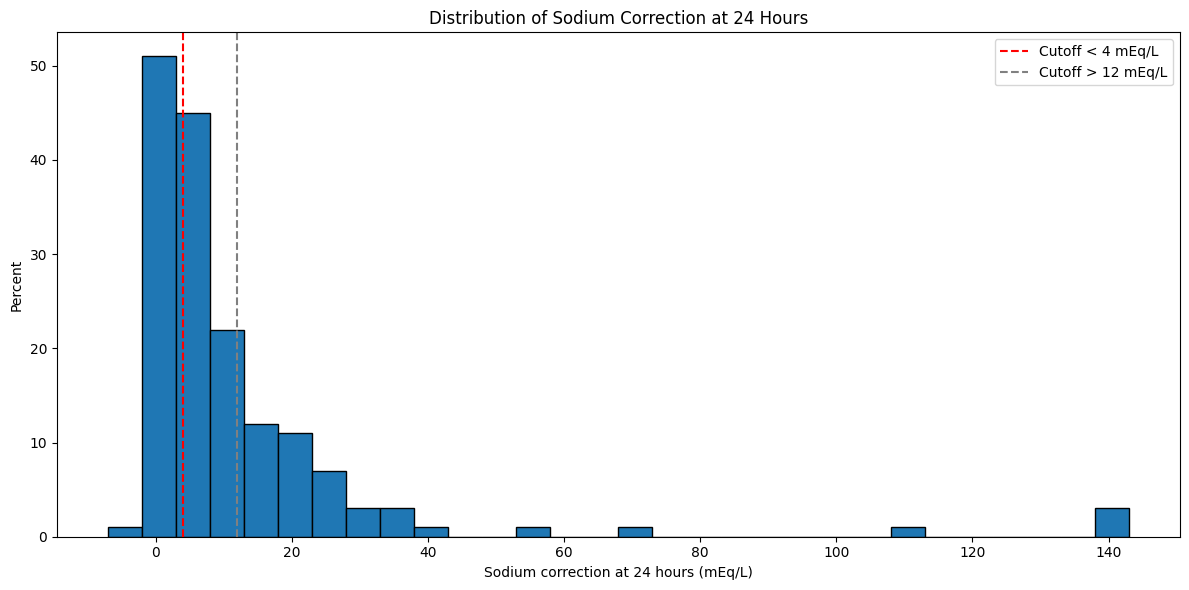

In [12]:
new_df['sodium_charttime'] = pd.to_datetime(new_df['sodium_charttime'])

sodium_correction_24h = []

grouped = new_df.groupby(['subject_id', 'hadm_id'])

# Calculate sodium correction at 24 hours for each patient
for name, group in grouped:
    group = group.sort_values(by='sodium_charttime')
    start_sodium = group['Sodium'].iloc[0]
    
    # Calculate sodium correction at 24 hours
    time_24h = group[group['sodium_charttime'] <= group['sodium_charttime'].iloc[0] + pd.Timedelta(hours=24)]
    if not time_24h.empty:
        correction_24h = time_24h['Sodium'].iloc[-1] - start_sodium
        sodium_correction_24h.append(correction_24h)

plt.figure(figsize=(12, 6))

# Define custom bins for finer intervals
bins = range(int(min(sodium_correction_24h)), int(max(sodium_correction_24h)) + 5, 5)

# Plot for 24 hours
plt.hist(sodium_correction_24h, bins=bins, edgecolor='black')
plt.axvline(x=4, color='red', linestyle='--', label='Cutoff < 4 mEq/L')
plt.axvline(x=12, color='gray', linestyle='--', label='Cutoff > 12 mEq/L')
plt.xlabel('Sodium correction at 24 hours (mEq/L)')
plt.ylabel('Percent')
plt.title('Distribution of Sodium Correction at 24 Hours')

# Set x-ticks to show every 2 units and limit x-axis to 15
#plt.xticks(range(-2, 15, 1), rotation=1)
#plt.xlim(-2, 15)
plt.legend()

plt.tight_layout()
plt.show()

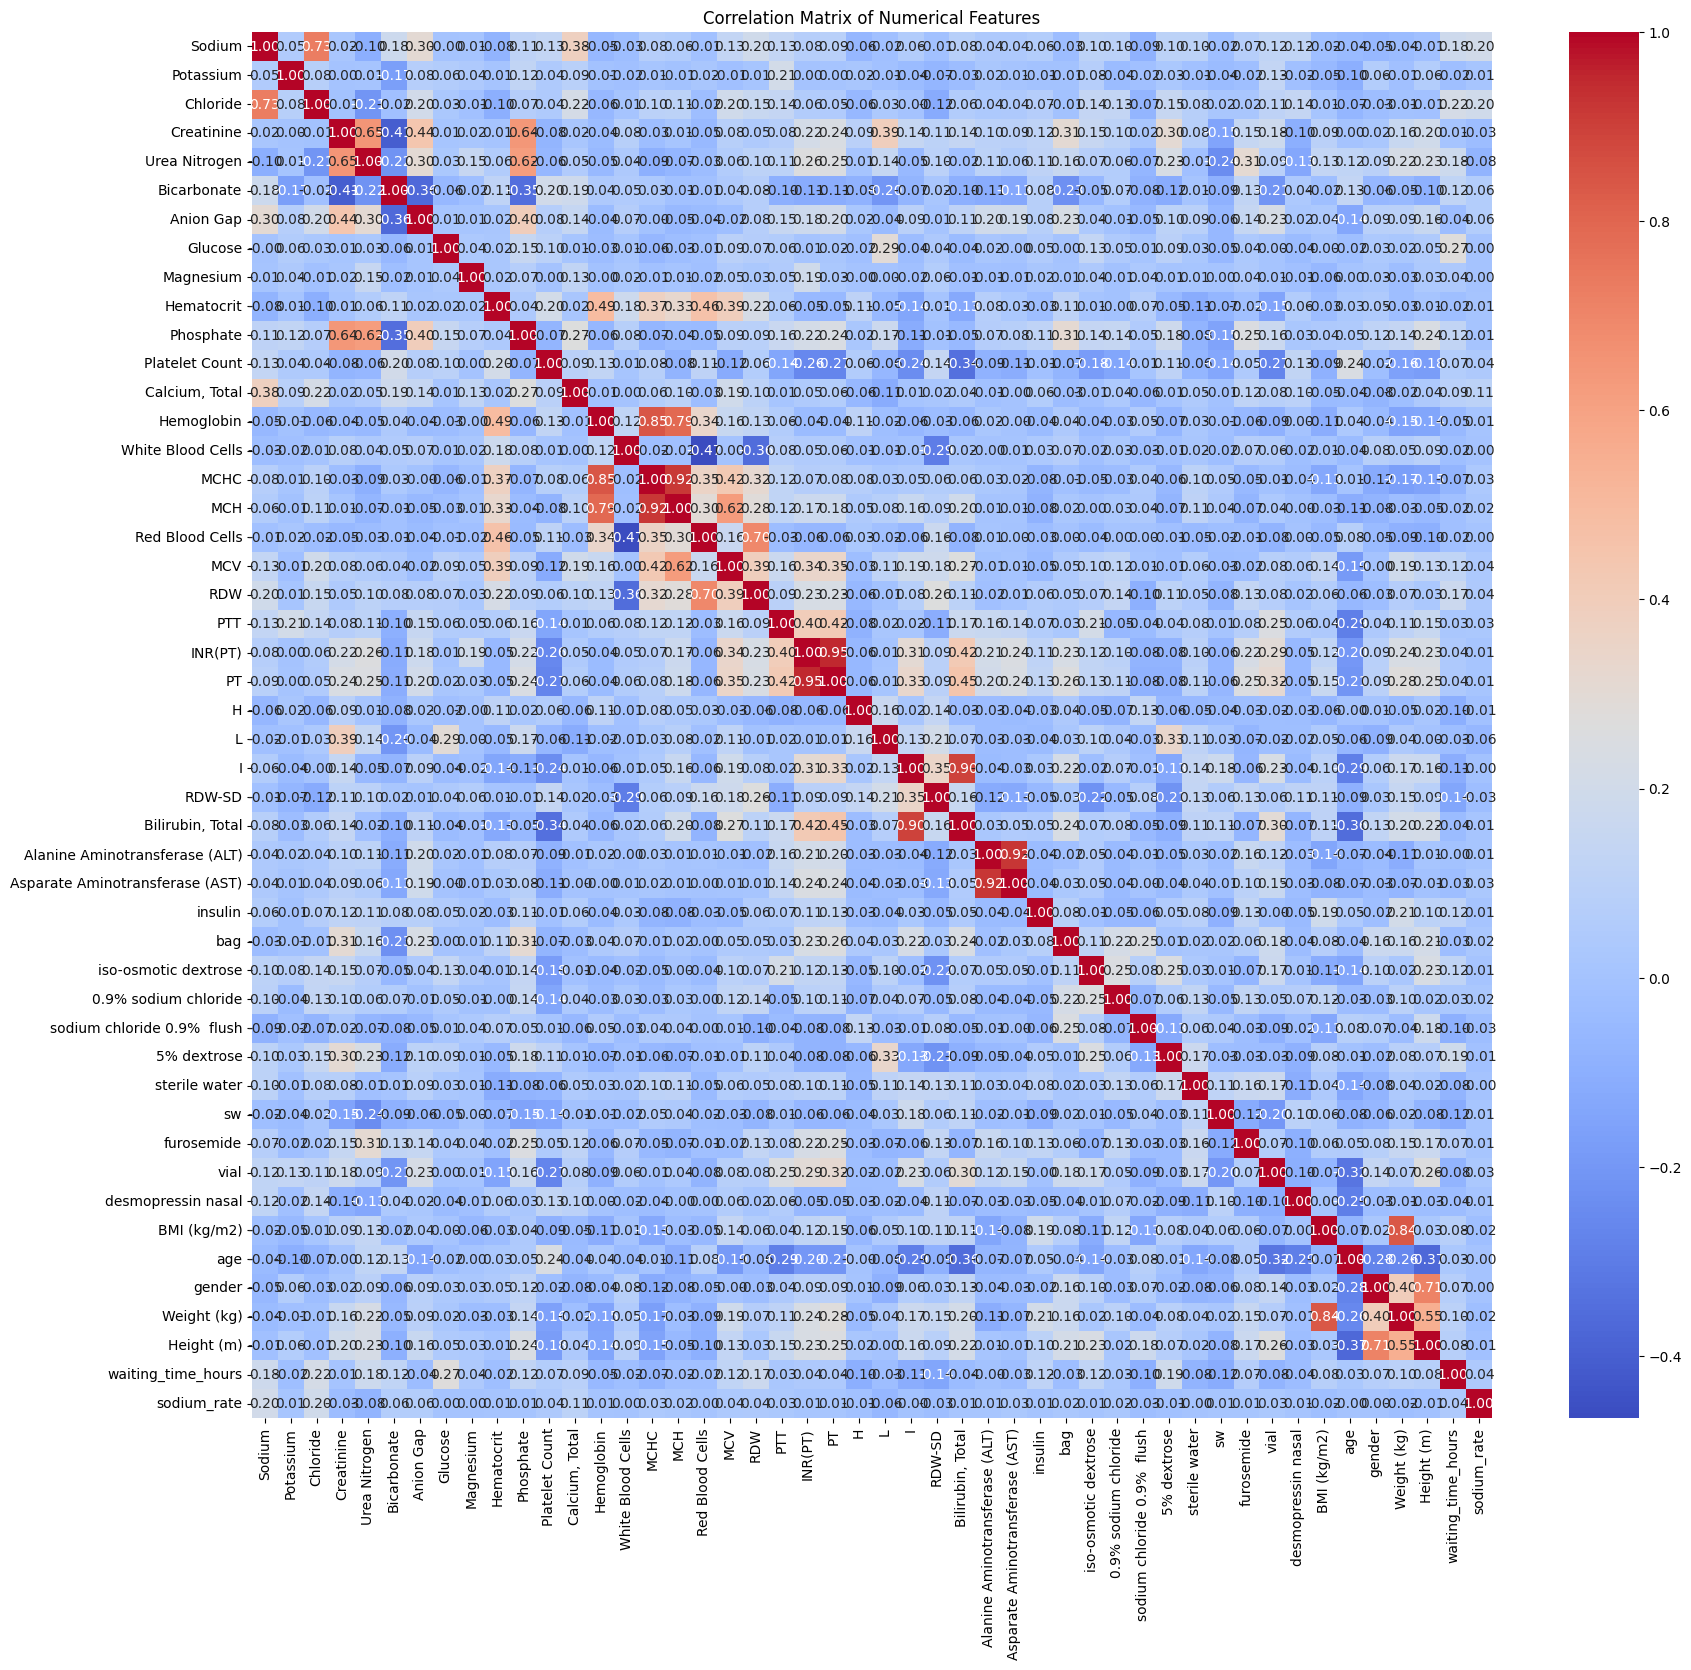

In [13]:
import seaborn as sns
# Select only numerical columns, excluding 'subject_id' and 'hadm_id'
numerical_columns = new_df.select_dtypes(include='number').drop(columns=['subject_id', 'hadm_id'])

# Calculate the correlation matrix
correlation_matrix = numerical_columns.corr()

# Plot the heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

/tmp/ipykernel_167315/3916564498.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_data['time_diff_hours'] = (normal_data['sodium_charttime'] - normal_time).dt.total_seconds() / 3600
/tmp/ipykernel_167315/3916564498.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  under_data['time_diff_hours'] = (under_data['sodium_charttime'] - under_time).dt.total_seconds() / 3600
/tmp/ipykernel_167315/3916564498.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

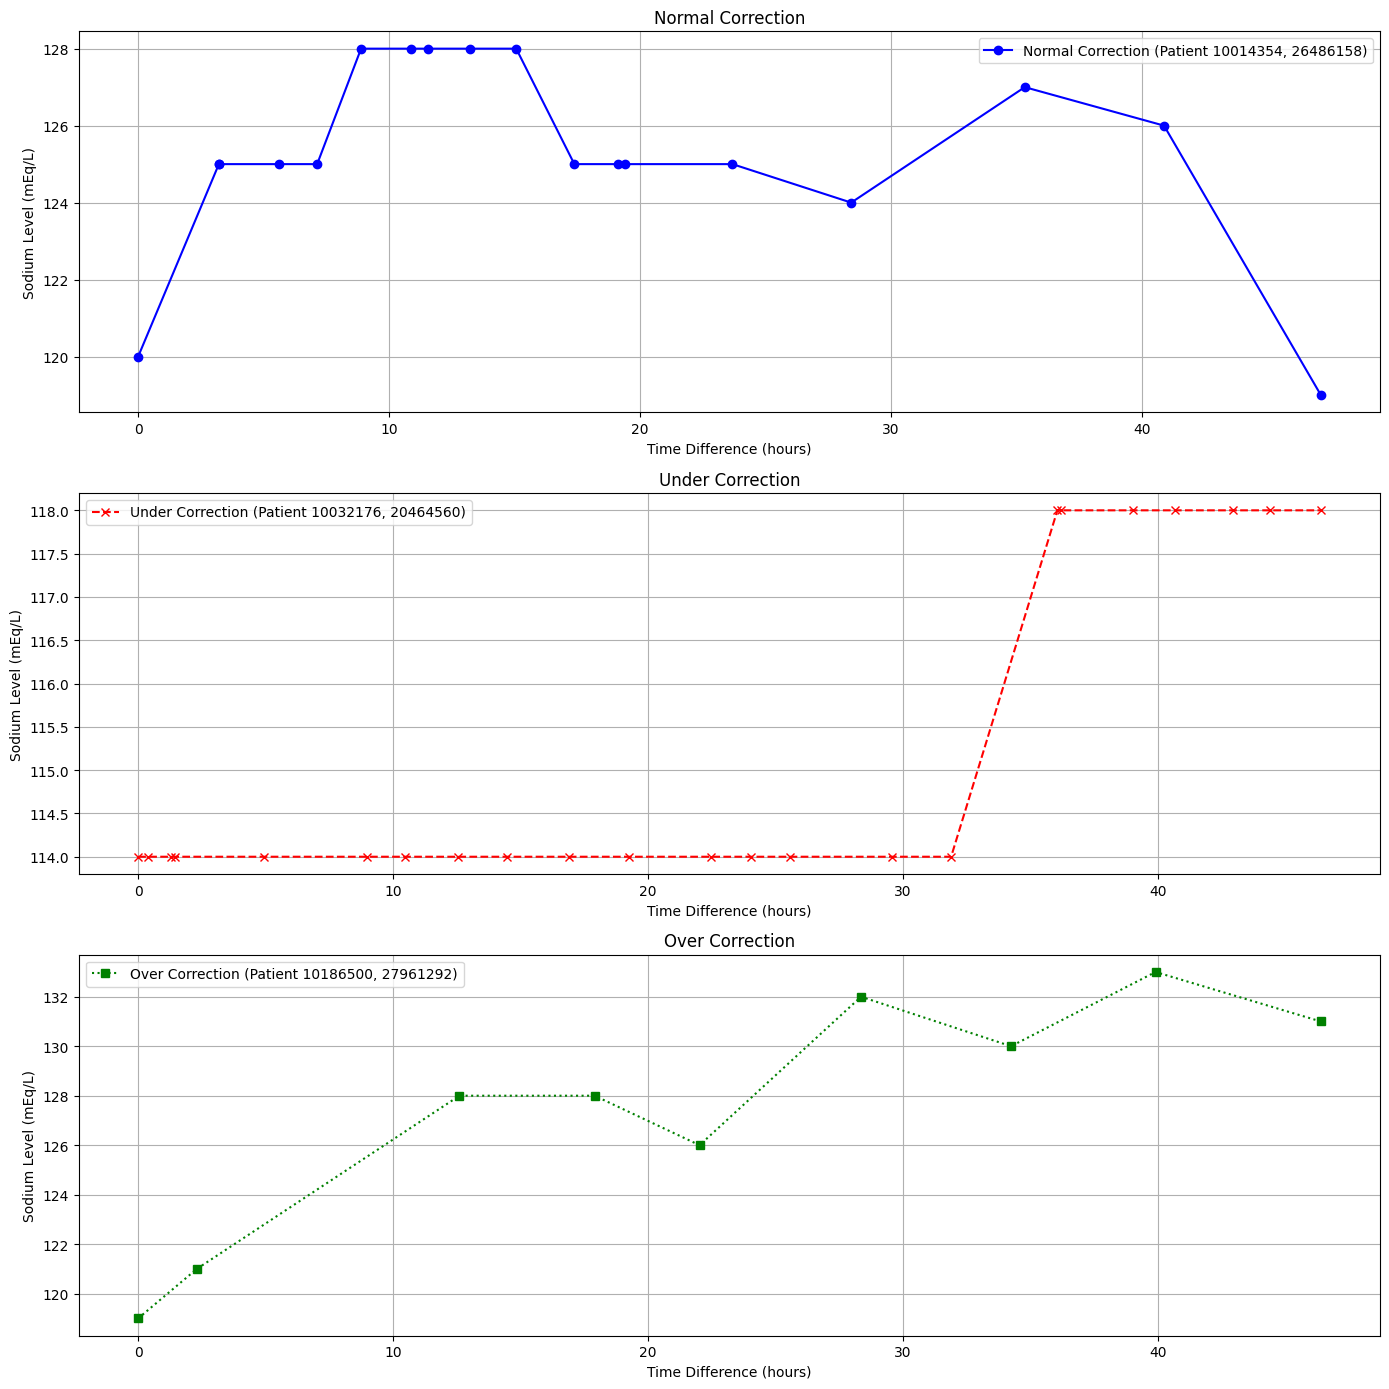

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' is your dataframe
data['sodium_charttime'] = pd.to_datetime(data['sodium_charttime'])

# Initialize placeholders for the patient information
normal_patient = pd.Series(dtype='object')
under_patient = pd.Series(dtype='object')
over_patient = pd.Series(dtype='object')

# Group by patient
grouped = data.groupby(['subject_id', 'hadm_id'])

# Function to find the first instance of sodium <= 120 and calculate sodium increase in 24 hours
def find_patient(group):
    first_below_120_time = group[group['Sodium'] <= 120]['sodium_charttime'].min()
    if pd.notnull(first_below_120_time):
        corrected_group = group[group['sodium_charttime'] >= first_below_120_time]
        end_time = first_below_120_time + pd.Timedelta(hours=24)
        end_group = corrected_group[corrected_group['sodium_charttime'] <= end_time]
        if not end_group.empty:
            sodium_increase = end_group['Sodium'].iloc[-1] - corrected_group['Sodium'].iloc[0]
            return sodium_increase, first_below_120_time
    return None, None

# Iterate through each group to find the patients
for name, group in grouped:
    if normal_patient.empty:
        increase, normal_time = find_patient(group)
        if increase is not None and 4 <= increase <= 6:
            normal_patient = group[['subject_id', 'hadm_id']].iloc[0]
    if under_patient.empty:
        increase, under_time = find_patient(group)
        if increase is not None and increase < 4:
            under_patient = group[['subject_id', 'hadm_id']].iloc[0]
    if over_patient.empty:
        increase, over_time = find_patient(group)
        if increase is not None and increase > 6:
            over_patient = group[['subject_id', 'hadm_id']].iloc[0]
    if not normal_patient.empty and not under_patient.empty and not over_patient.empty:
        break

# Ensure we found one patient of each type
if not normal_patient.empty and not under_patient.empty and not over_patient.empty:
    # Filter data for these patients from the instance where sodium <= 120 to 48 hours after
    normal_data = data[(data['subject_id'] == normal_patient['subject_id']) & 
                       (data['hadm_id'] == normal_patient['hadm_id']) &
                       (data['sodium_charttime'] >= normal_time) &
                       (data['sodium_charttime'] <= normal_time + pd.Timedelta(hours=48))]

    under_data = data[(data['subject_id'] == under_patient['subject_id']) & 
                      (data['hadm_id'] == under_patient['hadm_id']) &
                      (data['sodium_charttime'] >= under_time) &
                      (data['sodium_charttime'] <= under_time + pd.Timedelta(hours=48))]

    over_data = data[(data['subject_id'] == over_patient['subject_id']) & 
                     (data['hadm_id'] == over_patient['hadm_id']) &
                     (data['sodium_charttime'] >= over_time) &
                     (data['sodium_charttime'] <= over_time + pd.Timedelta(hours=48))]

    # Calculate time differences
    normal_data['time_diff_hours'] = (normal_data['sodium_charttime'] - normal_time).dt.total_seconds() / 3600
    under_data['time_diff_hours'] = (under_data['sodium_charttime'] - under_time).dt.total_seconds() / 3600
    over_data['time_diff_hours'] = (over_data['sodium_charttime'] - over_time).dt.total_seconds() / 3600

    # Plotting
    plt.figure(figsize=(14, 14))

    # Plot for normal correction patient
    plt.subplot(3, 1, 1)
    plt.plot(normal_data['time_diff_hours'], normal_data['Sodium'], label=f'Normal Correction (Patient {normal_patient["subject_id"]}, {normal_patient["hadm_id"]})', marker='o', linestyle='-', color='blue')
    plt.xlabel('Time Difference (hours)')
    plt.ylabel('Sodium Level (mEq/L)')
    plt.title('Normal Correction')
    plt.legend()
    plt.grid(True)

    # Plot for under correction patient
    plt.subplot(3, 1, 2)
    plt.plot(under_data['time_diff_hours'], under_data['Sodium'], label=f'Under Correction (Patient {under_patient["subject_id"]}, {under_patient["hadm_id"]})', marker='x', linestyle='--', color='red')
    plt.xlabel('Time Difference (hours)')
    plt.ylabel('Sodium Level (mEq/L)')
    plt.title('Under Correction')
    plt.legend()
    plt.grid(True)

    # Plot for over correction patient
    plt.subplot(3, 1, 3)
    plt.plot(over_data['time_diff_hours'], over_data['Sodium'], label=f'Over Correction (Patient {over_patient["subject_id"]}, {over_patient["hadm_id"]})', marker='s', linestyle=':', color='green')
    plt.xlabel('Time Difference (hours)')
    plt.ylabel('Sodium Level (mEq/L)')
    plt.title('Over Correction')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

else:
    print("Unable to find one patient for each correction category.")

/tmp/ipykernel_167315/1350491965.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_data['time_diff_hours'] = (normal_data['sodium_charttime'] - normal_time).dt.total_seconds() / 3600
/tmp/ipykernel_167315/1350491965.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  under_data['time_diff_hours'] = (under_data['sodium_charttime'] - under_time).dt.total_seconds() / 3600
/tmp/ipykernel_167315/1350491965.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

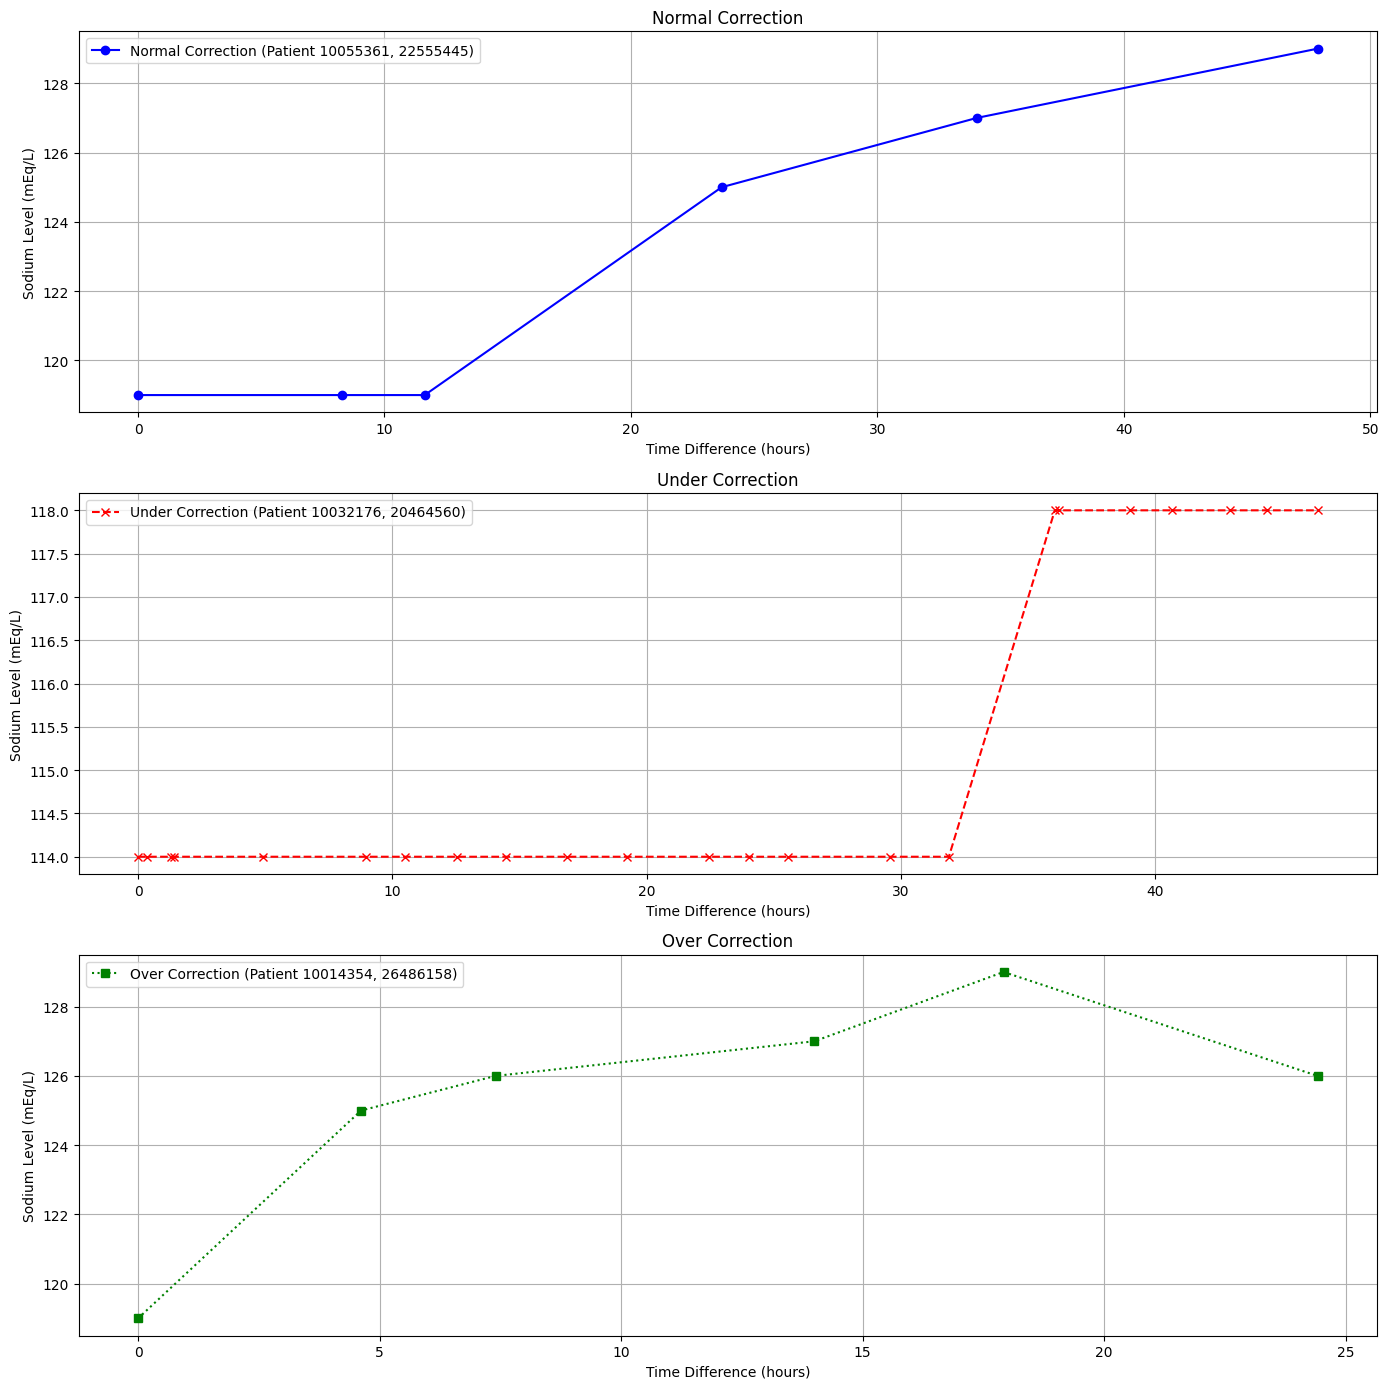

In [15]:
new_df['sodium_charttime'] = pd.to_datetime(new_df['sodium_charttime'])

# Initialize placeholders for the patient information
normal_patient = pd.Series(dtype='object')
under_patient = pd.Series(dtype='object')
over_patient = pd.Series(dtype='object')

# Group by patient
grouped = new_df.groupby(['subject_id', 'hadm_id'])

# Function to find the first instance of sodium <= 120 and calculate sodium increase in 24 hours
def find_patient(group):
    first_below_120_time = group[group['Sodium'] <= 120]['sodium_charttime'].min()
    if pd.notnull(first_below_120_time):
        corrected_group = group[group['sodium_charttime'] >= first_below_120_time]
        end_time = first_below_120_time + pd.Timedelta(hours=24)
        end_group = corrected_group[corrected_group['sodium_charttime'] <= end_time]
        if not end_group.empty:
            sodium_increase = end_group['Sodium'].iloc[-1] - corrected_group['Sodium'].iloc[0]
            return sodium_increase, first_below_120_time
    return None, None

# Iterate through each group to find the patients
for name, group in grouped:
    if normal_patient.empty:
        increase, normal_time = find_patient(group)
        if increase is not None and 4 <= increase <= 6:
            normal_patient = group[['subject_id', 'hadm_id']].iloc[0]
    if under_patient.empty:
        increase, under_time = find_patient(group)
        if increase is not None and increase < 4:
            under_patient = group[['subject_id', 'hadm_id']].iloc[0]
    if over_patient.empty:
        increase, over_time = find_patient(group)
        if increase is not None and increase > 6:
            over_patient = group[['subject_id', 'hadm_id']].iloc[0]
    if not normal_patient.empty and not under_patient.empty and not over_patient.empty:
        break

# Ensure we found one patient of each type
if not normal_patient.empty and not under_patient.empty and not over_patient.empty:
    # Filter data for these patients from the instance where sodium <= 120 to 48 hours after
    normal_data = new_df[(new_df['subject_id'] == normal_patient['subject_id']) & 
                       (new_df['hadm_id'] == normal_patient['hadm_id']) &
                       (new_df['sodium_charttime'] >= normal_time) &
                       (new_df['sodium_charttime'] <= normal_time + pd.Timedelta(hours=48))]

    under_data = new_df[(new_df['subject_id'] == under_patient['subject_id']) & 
                      (new_df['hadm_id'] == under_patient['hadm_id']) &
                      (new_df['sodium_charttime'] >= under_time) &
                      (new_df['sodium_charttime'] <= under_time + pd.Timedelta(hours=48))]

    over_data = new_df[(new_df['subject_id'] == over_patient['subject_id']) & 
                     (new_df['hadm_id'] == over_patient['hadm_id']) &
                     (new_df['sodium_charttime'] >= over_time) &
                     (new_df['sodium_charttime'] <= over_time + pd.Timedelta(hours=48))]

    # Calculate time differences
    normal_data['time_diff_hours'] = (normal_data['sodium_charttime'] - normal_time).dt.total_seconds() / 3600
    under_data['time_diff_hours'] = (under_data['sodium_charttime'] - under_time).dt.total_seconds() / 3600
    over_data['time_diff_hours'] = (over_data['sodium_charttime'] - over_time).dt.total_seconds() / 3600

    # Plotting
    plt.figure(figsize=(14, 14))

    # Plot for normal correction patient
    plt.subplot(3, 1, 1)
    plt.plot(normal_data['time_diff_hours'], normal_data['Sodium'], label=f'Normal Correction (Patient {normal_patient["subject_id"]}, {normal_patient["hadm_id"]})', marker='o', linestyle='-', color='blue')
    plt.xlabel('Time Difference (hours)')
    plt.ylabel('Sodium Level (mEq/L)')
    plt.title('Normal Correction')
    plt.legend()
    plt.grid(True)

    # Plot for under correction patient
    plt.subplot(3, 1, 2)
    plt.plot(under_data['time_diff_hours'], under_data['Sodium'], label=f'Under Correction (Patient {under_patient["subject_id"]}, {under_patient["hadm_id"]})', marker='x', linestyle='--', color='red')
    plt.xlabel('Time Difference (hours)')
    plt.ylabel('Sodium Level (mEq/L)')
    plt.title('Under Correction')
    plt.legend()
    plt.grid(True)

    # Plot for over correction patient
    plt.subplot(3, 1, 3)
    plt.plot(over_data['time_diff_hours'], over_data['Sodium'], label=f'Over Correction (Patient {over_patient["subject_id"]}, {over_patient["hadm_id"]})', marker='s', linestyle=':', color='green')
    plt.xlabel('Time Difference (hours)')
    plt.ylabel('Sodium Level (mEq/L)')
    plt.title('Over Correction')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

else:
    print("Unable to find one patient for each correction category.")


Mean: 6.012345679012346
Median: 2.0
Mode: 0
Min: 0
Max: 34


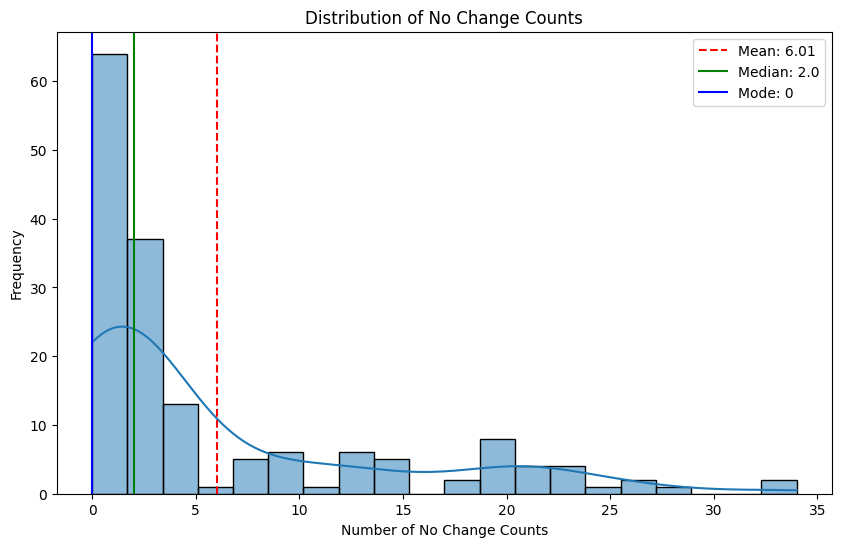

In [16]:
# Calculate the statistics
mean_value = no_change_counts_df['no_change_count'].mean()
median_value = no_change_counts_df['no_change_count'].median()
mode_value = no_change_counts_df['no_change_count'].mode().iloc[0]
min_value = no_change_counts_df['no_change_count'].min()
max_value = no_change_counts_df['no_change_count'].max()

# Print the statistics
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Mode: {mode_value}")
print(f"Min: {min_value}")
print(f"Max: {max_value}")

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(no_change_counts_df['no_change_count'], bins=20, kde=True)
plt.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='g', linestyle='-', label=f'Median: {median_value}')
plt.axvline(mode_value, color='b', linestyle='-', label=f'Mode: {mode_value}')
plt.xlabel('Number of No Change Counts')
plt.ylabel('Frequency')
plt.title('Distribution of No Change Counts')
plt.legend()
plt.show()

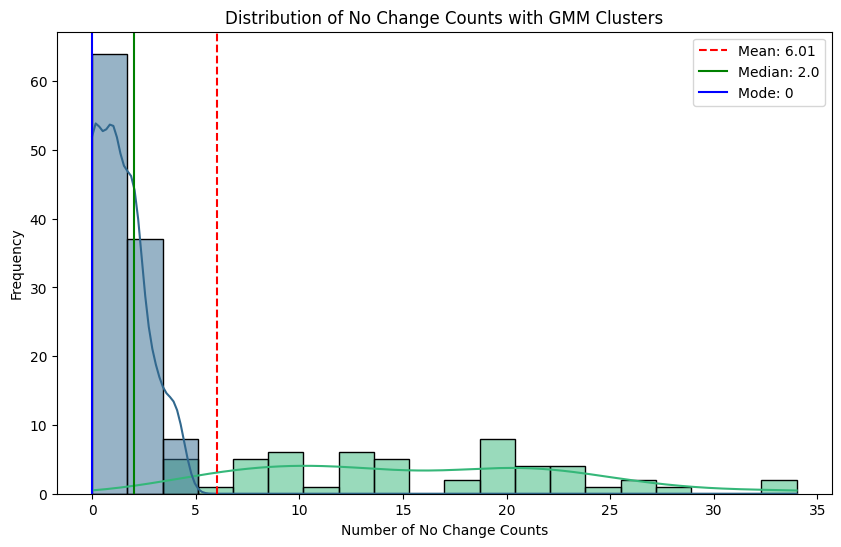

Mean of GMM component 0: 1.36
Mean of GMM component 1: 14.93


In [17]:
from sklearn.mixture import GaussianMixture

# Reshape the data for GMM
data_for_gmm = no_change_counts_df['no_change_count'].values.reshape(-1, 1)

# Fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data_for_gmm)

# Predict the component for each sample
gmm_labels = gmm.predict(data_for_gmm)

# Add the GMM labels to the dataframe
no_change_counts_df['gmm_label'] = gmm_labels

# Plot the distribution with GMM labels
plt.figure(figsize=(10, 6))
sns.histplot(no_change_counts_df, x='no_change_count', hue='gmm_label', bins=20, kde=True, palette='viridis')
plt.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='g', linestyle='-', label=f'Median: {median_value}')
plt.axvline(mode_value, color='b', linestyle='-', label=f'Mode: {mode_value}')
plt.xlabel('Number of No Change Counts')
plt.ylabel('Frequency')
plt.title('Distribution of No Change Counts with GMM Clusters')
plt.legend()
plt.show()

# Display the means of the GMM components
for i in range(2):
    component_mean = gmm.means_[i, 0]
    print(f"Mean of GMM component {i}: {component_mean:.2f}")

In [18]:
# Merge the GMM labels back into the new_df
new_df_with_labels = new_df.merge(no_change_counts_df[['subject_id', 'hadm_id', 'gmm_label']], on=['subject_id', 'hadm_id'], how='left')

# Create separate dataframes for each GMM component
component_0_df = new_df_with_labels[new_df_with_labels['gmm_label'] == 0]
component_1_df = new_df_with_labels[new_df_with_labels['gmm_label'] == 1]

#component_0_df.to_csv('component_0_patients.csv', index=False)
#component_1_df.to_csv('component_1_patients.csv', index=False)

# Display the first few rows of each dataframe to verify
print("Component 0 Patients:")
print(component_0_df.head())

print("\nComponent 1 Patients:")
print(component_1_df.head())

Component 0 Patients:
   subject_id   hadm_id    sodium_charttime  Sodium  Potassium  Chloride  \
0    10014354  26486158 2148-08-26 12:15:00   119.0        5.0      87.0   
1    10014354  26486158 2148-08-26 16:52:00   125.0        4.8      85.0   
2    10014354  26486158 2148-08-26 19:39:00   126.0        4.9      88.0   
3    10014354  26486158 2148-08-27 02:15:00   127.0        4.7      89.0   
4    10014354  26486158 2148-08-27 06:10:00   129.0        4.7      90.0   

   Creatinine  Urea Nitrogen  Bicarbonate  Anion Gap  ...  BMI (kg/m2)  age  \
0         1.6           26.0         23.0        9.0  ...    36.698936   60   
1         1.4           25.0         24.0       16.0  ...    36.698936   60   
2         1.4           25.0         22.0       16.0  ...    36.698936   60   
3         1.5           25.0         24.0       14.0  ...    36.698936   60   
4         1.4           24.0         23.0       16.0  ...    36.698936   60   

   gender  Weight (kg)  Height (m)  waiting_ti

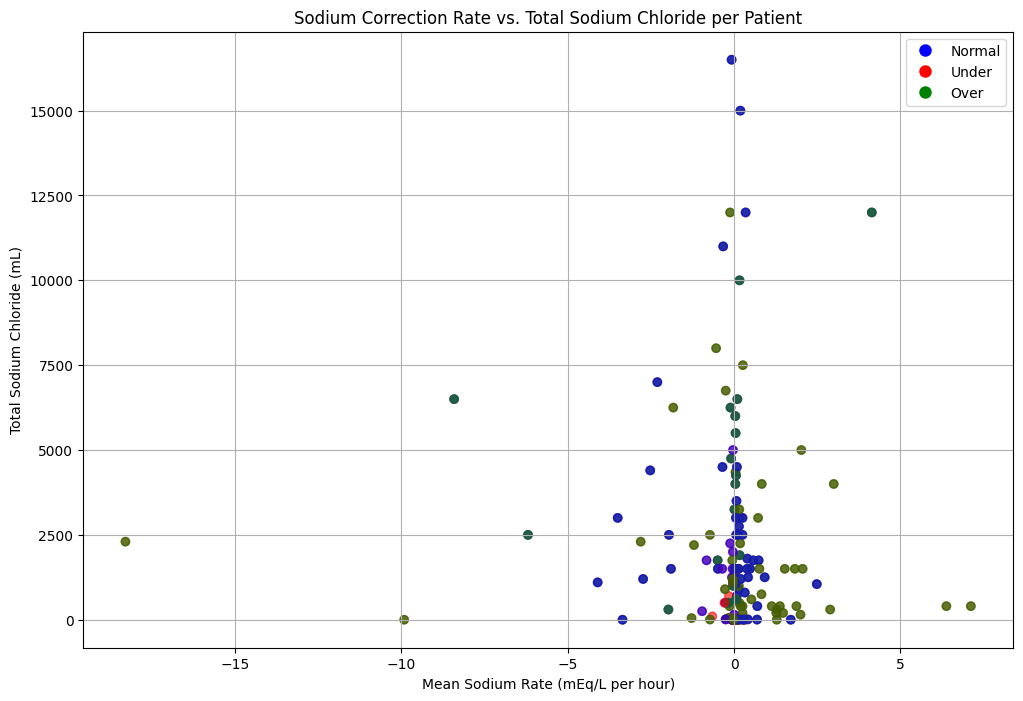

In [19]:
# Group by subject_id and hadm_id to calculate the total 0.9% sodium chloride for each patient
total_sodium_chloride_per_patient = new_df.groupby(['subject_id', 'hadm_id'])['0.9% sodium chloride'].sum().reset_index()

# Calculate the mean sodium rate for each patient over the filtered period
mean_sodium_rate_per_patient = new_df.groupby(['subject_id', 'hadm_id'])['sodium_rate'].mean().reset_index()

# Merge the total sodium chloride and mean sodium rate back with the new_df to get the 'correction' column
patient_data = total_sodium_chloride_per_patient.merge(
    mean_sodium_rate_per_patient,
    on=['subject_id', 'hadm_id']
).merge(
    new_df[['subject_id', 'hadm_id', 'correction']].drop_duplicates(), 
    on=['subject_id', 'hadm_id'], 
    how='left'
)

# Rename columns for clarity
patient_data.rename(columns={'0.9% sodium chloride': 'total_sodium_chloride', 'sodium_rate': 'mean_sodium_rate'}, inplace=True)

plt.figure(figsize=(12, 8))
# Scatter plot
plt.scatter(patient_data['mean_sodium_rate'], patient_data['total_sodium_chloride'], c=patient_data['correction'].map({'normal': 'blue', 'under': 'red', 'over': 'green'}), alpha=0.6)
plt.xlabel('Mean Sodium Rate (mEq/L per hour)')
plt.ylabel('Total Sodium Chloride (mL)')
plt.title('Sodium Correction Rate vs. Total Sodium Chloride per Patient')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Normal'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Under'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Over')])
plt.grid(True)
plt.show()

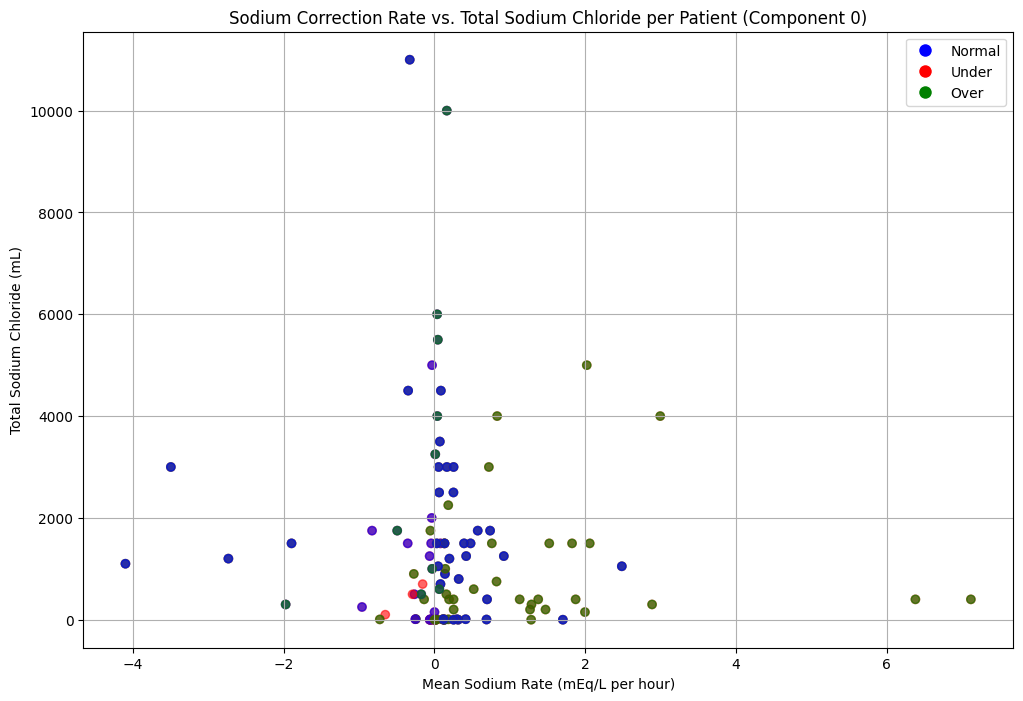

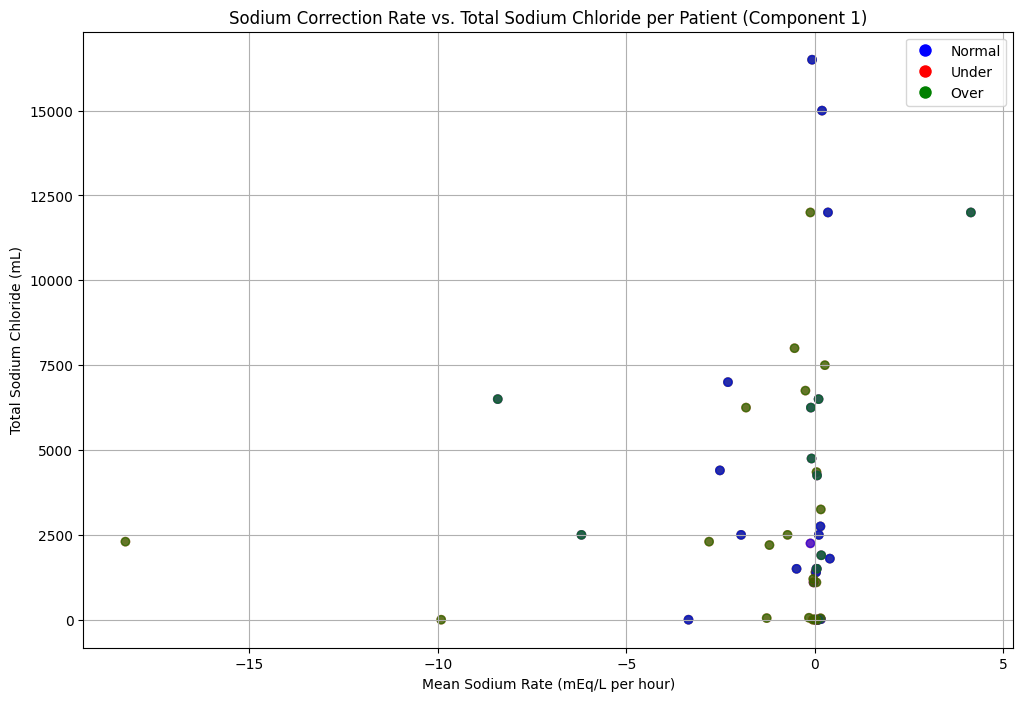

In [20]:
patient_data_with_labels = patient_data.merge(no_change_counts_df[['subject_id', 'hadm_id', 'gmm_label']], on=['subject_id', 'hadm_id'], how='left')

# Separate dataframes for each component
component_0_data = patient_data_with_labels[patient_data_with_labels['gmm_label'] == 0]
component_1_data = patient_data_with_labels[patient_data_with_labels['gmm_label'] == 1]

# Function to create the scatter plot
def plot_sodium_correction_rate_vs_total_sodium_chloride(component_data, component_label):
    plt.figure(figsize=(12, 8))
    plt.scatter(component_data['mean_sodium_rate'], component_data['total_sodium_chloride'], 
                c=component_data['correction'].map({'normal': 'blue', 'under': 'red', 'over': 'green'}), alpha=0.6)
    plt.xlabel('Mean Sodium Rate (mEq/L per hour)')
    plt.ylabel('Total Sodium Chloride (mL)')
    plt.title(f'Sodium Correction Rate vs. Total Sodium Chloride per Patient (Component {component_label})')
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Normal'),
                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Under'),
                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Over')])
    plt.grid(True)
    plt.show()

# Create scatter plot for component 0
plot_sodium_correction_rate_vs_total_sodium_chloride(component_0_data, 0)

# Create scatter plot for component 1
plot_sodium_correction_rate_vs_total_sodium_chloride(component_1_data, 1)

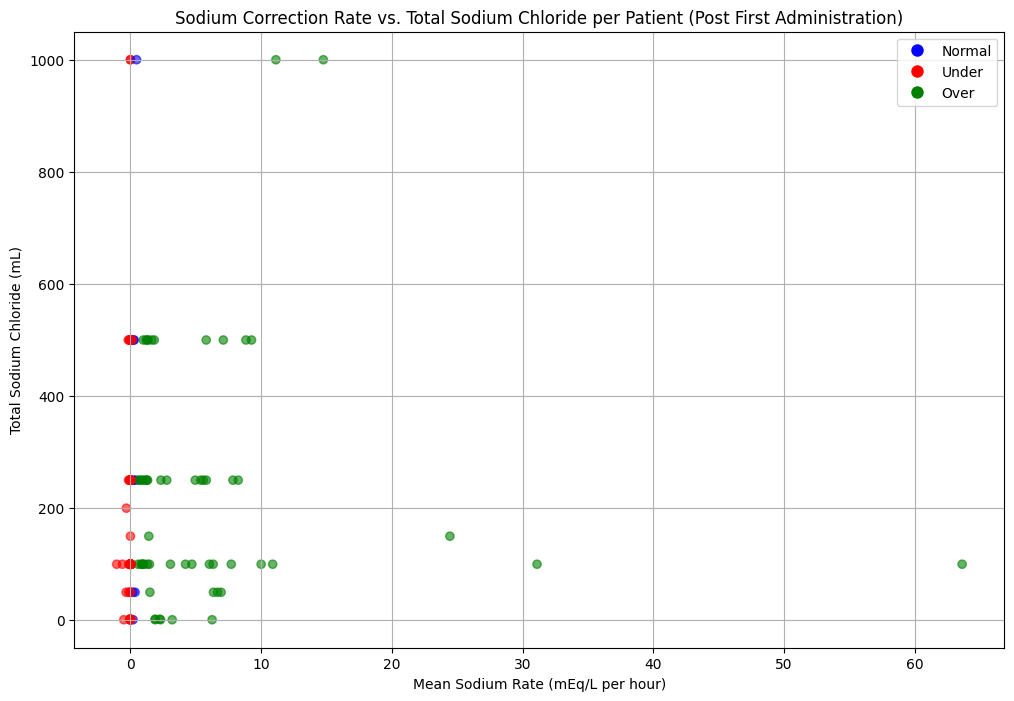

In [21]:
new_df['sodium_charttime'] = pd.to_datetime(new_df['sodium_charttime'])

# Sort the dataframe by subject_id, hadm_id, and sodium_charttime
new_df = new_df.sort_values(by=['subject_id', 'hadm_id', 'sodium_charttime'])

# Filter to keep only the first administration of sodium solution for each patient
first_sodium_admin = new_df[new_df['0.9% sodium chloride'] > 0].groupby(['subject_id', 'hadm_id']).first().reset_index()

# Extract the sodium_charttime of the first sodium administration
first_admin_times = first_sodium_admin[['subject_id', 'hadm_id', 'sodium_charttime']]

# Merge this information back to the original dataframe to get subsequent correction types
merged_df = pd.merge(new_df, first_admin_times, on=['subject_id', 'hadm_id'], suffixes=('', '_first_admin'))

# Filter to keep only records after the first sodium administration
post_first_admin = merged_df[merged_df['sodium_charttime'] > merged_df['sodium_charttime_first_admin']]

# Get the first correction type after the first sodium administration
first_correction_post_admin = post_first_admin.groupby(['subject_id', 'hadm_id']).first().reset_index()

# Calculate the mean sodium rate for each patient over the filtered period (first instances)
mean_sodium_rate_per_patient = first_correction_post_admin.groupby(['subject_id', 'hadm_id'])['sodium_rate'].mean().reset_index()

# Calculate the total 0.9% sodium chloride for each patient over the filtered period (first instances)
total_sodium_chloride_per_patient = first_sodium_admin.groupby(['subject_id', 'hadm_id'])['0.9% sodium chloride'].sum().reset_index()

# Merge the total sodium chloride and mean sodium rate back with the first_correction_post_admin to get the 'correction' column
patient_data = total_sodium_chloride_per_patient.merge(
    mean_sodium_rate_per_patient,
    on=['subject_id', 'hadm_id']
).merge(
    first_correction_post_admin[['subject_id', 'hadm_id', 'correction']].drop_duplicates(), 
    on=['subject_id', 'hadm_id'], 
    how='left'
)

# Rename columns for clarity
patient_data.rename(columns={'0.9% sodium chloride': 'total_sodium_chloride', 'sodium_rate': 'mean_sodium_rate'}, inplace=True)

plt.figure(figsize=(12, 8))
# Scatter plot
plt.scatter(patient_data['mean_sodium_rate'], patient_data['total_sodium_chloride'], c=patient_data['correction'].map({'normal': 'blue', 'under': 'red', 'over': 'green'}), alpha=0.6)
plt.xlabel('Mean Sodium Rate (mEq/L per hour)')
plt.ylabel('Total Sodium Chloride (mL)')
plt.title('Sodium Correction Rate vs. Total Sodium Chloride per Patient (Post First Administration)')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Normal'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Under'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Over')])
plt.grid(True)
plt.show()

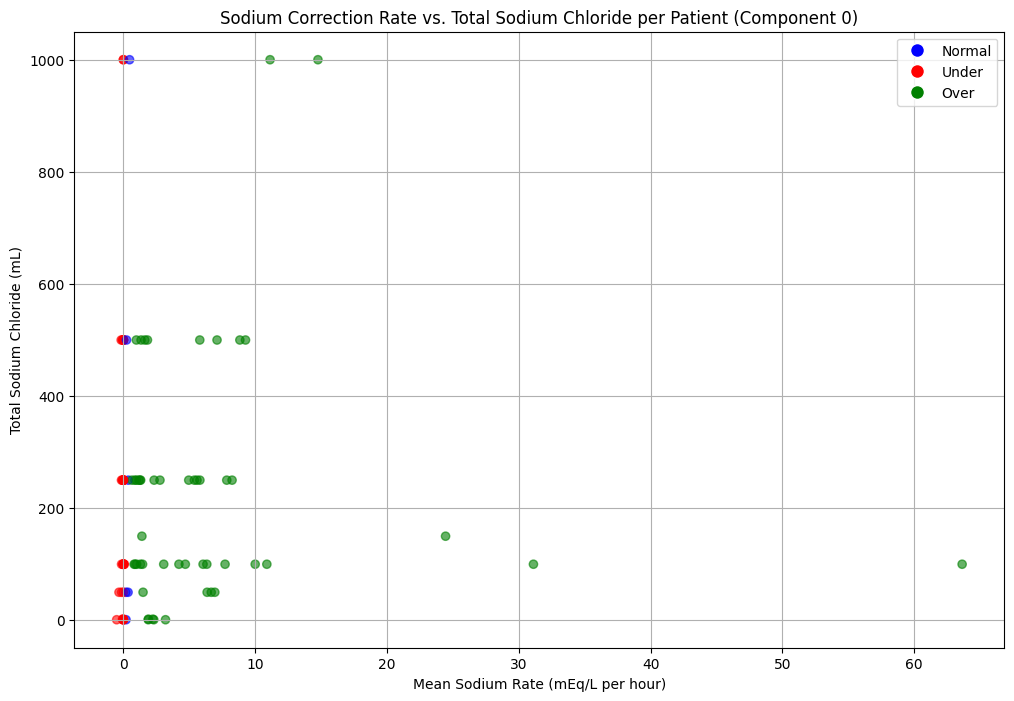

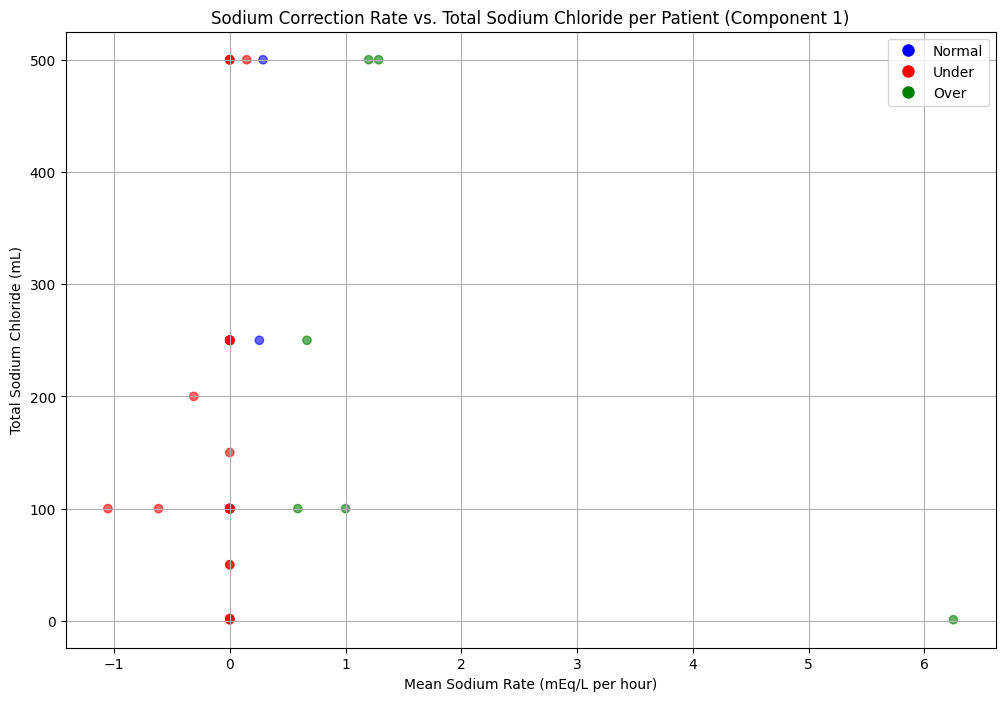

In [22]:
new_df['sodium_charttime'] = pd.to_datetime(new_df['sodium_charttime'])

# Sort the dataframe by subject_id, hadm_id, and sodium_charttime
new_df = new_df.sort_values(by=['subject_id', 'hadm_id', 'sodium_charttime'])

# Filter to keep only the first administration of sodium solution for each patient
first_sodium_admin = new_df[new_df['0.9% sodium chloride'] > 0].groupby(['subject_id', 'hadm_id']).first().reset_index()

# Extract the sodium_charttime of the first sodium administration
first_admin_times = first_sodium_admin[['subject_id', 'hadm_id', 'sodium_charttime']]

# Merge this information back to the original dataframe to get subsequent correction types
merged_df = pd.merge(new_df, first_admin_times, on=['subject_id', 'hadm_id'], suffixes=('', '_first_admin'))

# Filter to keep only records after the first sodium administration
post_first_admin = merged_df[merged_df['sodium_charttime'] > merged_df['sodium_charttime_first_admin']]

# Get the first correction type after the first sodium administration
first_correction_post_admin = post_first_admin.groupby(['subject_id', 'hadm_id']).first().reset_index()

# Calculate the mean sodium rate for each patient over the filtered period (first instances)
mean_sodium_rate_per_patient = first_correction_post_admin.groupby(['subject_id', 'hadm_id'])['sodium_rate'].mean().reset_index()

# Calculate the total 0.9% sodium chloride for each patient over the filtered period (first instances)
total_sodium_chloride_per_patient = first_sodium_admin.groupby(['subject_id', 'hadm_id'])['0.9% sodium chloride'].sum().reset_index()

# Merge the total sodium chloride and mean sodium rate back with the first_correction_post_admin to get the 'correction' column
patient_data = total_sodium_chloride_per_patient.merge(
    mean_sodium_rate_per_patient,
    on=['subject_id', 'hadm_id']
).merge(
    first_correction_post_admin[['subject_id', 'hadm_id', 'correction']].drop_duplicates(), 
    on=['subject_id', 'hadm_id'], 
    how='left'
)

# Rename columns for clarity
patient_data.rename(columns={'0.9% sodium chloride': 'total_sodium_chloride', 'sodium_rate': 'mean_sodium_rate'}, inplace=True)

# Merge the GMM labels with patient data
patient_data_with_labels = patient_data.merge(no_change_counts_df[['subject_id', 'hadm_id', 'gmm_label']], on=['subject_id', 'hadm_id'], how='left')

# Separate dataframes for each component
component_0_data = patient_data_with_labels[patient_data_with_labels['gmm_label'] == 0]
component_1_data = patient_data_with_labels[patient_data_with_labels['gmm_label'] == 1]

# Function to create the scatter plot
def plot_sodium_correction_rate_vs_total_sodium_chloride(component_data, component_label):
    plt.figure(figsize=(12, 8))
    plt.scatter(component_data['mean_sodium_rate'], component_data['total_sodium_chloride'], 
                c=component_data['correction'].map({'normal': 'blue', 'under': 'red', 'over': 'green'}), alpha=0.6)
    plt.xlabel('Mean Sodium Rate (mEq/L per hour)')
    plt.ylabel('Total Sodium Chloride (mL)')
    plt.title(f'Sodium Correction Rate vs. Total Sodium Chloride per Patient (Component {component_label})')
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Normal'),
                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Under'),
                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Over')])
    plt.grid(True)
    plt.show()

# Create scatter plot for component 0
plot_sodium_correction_rate_vs_total_sodium_chloride(component_0_data, 0)

# Create scatter plot for component 1
plot_sodium_correction_rate_vs_total_sodium_chloride(component_1_data, 1)

In [23]:
new_df_with_labels = new_df.merge(no_change_counts_df[['subject_id', 'hadm_id', 'gmm_label']], on=['subject_id', 'hadm_id'], how='left')

# Separate dataframes for each component
component_0_df = new_df_with_labels[new_df_with_labels['gmm_label'] == 0]
component_1_df = new_df_with_labels[new_df_with_labels['gmm_label'] == 1]

def calculate_correction_stats(df):
    # Group by subject_id and hadm_id to calculate the total 0.9% sodium chloride for each patient
    total_sodium_chloride_per_patient = df.groupby(['subject_id', 'hadm_id'])['0.9% sodium chloride'].sum().reset_index()

    # Merge the total sodium chloride back with the df to get the 'correction' column
    total_sodium_chloride_per_patient = total_sodium_chloride_per_patient.merge(
        df[['subject_id', 'hadm_id', 'correction']].drop_duplicates(), 
        on=['subject_id', 'hadm_id'], 
        how='left'
    )

    # Group by 'correction' and calculate the average, min, max, and third standard deviation of total sodium chloride
    correction_stats = total_sodium_chloride_per_patient.groupby('correction')['0.9% sodium chloride'].agg(
        mean='mean',
        min='min',
        max='max',
        range=lambda x: x.max() - x.min(),
        std_dev_3=lambda x: 3 * np.std(x)
    ).reset_index()

    print(f"Correction Stats for component:\n{correction_stats}")

    # Group by subject_id and hadm_id to calculate the total 0.9% sodium chloride flush for each patient
    total_sodium_chloride_flush_per_patient = df.groupby(['subject_id', 'hadm_id'])['sodium chloride 0.9%  flush'].sum().reset_index()

    # Merge the total sodium chloride flush back with the df to get the 'correction' column
    total_sodium_chloride_flush_per_patient = total_sodium_chloride_flush_per_patient.merge(
        df[['subject_id', 'hadm_id', 'correction']].drop_duplicates(), 
        on=['subject_id', 'hadm_id'], 
        how='left'
    )

    # Group by 'correction' and calculate the average, min, max, range, and third standard deviation of total sodium chloride flush
    correction_flush_stats = total_sodium_chloride_flush_per_patient.groupby('correction')['sodium chloride 0.9%  flush'].agg(
        mean='mean',
        min='min',
        max='max',
        range=lambda x: x.max() - x.min(),
        std_dev_3=lambda x: 3 * np.std(x)
    ).reset_index()

    print(f"Correction Flush Stats for component:\n{correction_flush_stats}")

# Calculate and print stats for component 0
calculate_correction_stats(component_0_df)

# Calculate and print stats for component 1
calculate_correction_stats(component_1_df)

Correction Stats for component:
  correction         mean  min      max    range    std_dev_3
0     normal  1653.343284  0.0  11000.0  11000.0  6414.244328
1       over  1473.943820  0.0  11000.0  11000.0  5909.377096
2      under  1356.908257  0.0  11000.0  11000.0  5597.387243
Correction Flush Stats for component:
  correction       mean  min    max  range   std_dev_3
0     normal  39.955224  0.0  240.0  240.0  154.750897
1       over  39.623596  0.0  240.0  240.0  150.362979
2      under  37.619266  0.0  240.0  240.0  139.537195
Correction Stats for component:
  correction         mean  min      max    range     std_dev_3
0     normal  4081.586207  0.0  16500.0  16500.0  13449.003946
1       over  3478.039216  0.0  16500.0  16500.0  12237.311267
2      under  3410.000000  0.0  16500.0  16500.0  12053.028512
Correction Flush Stats for component:
  correction        mean  min     max   range    std_dev_3
0     normal  247.086207  0.0  3300.0  3300.0  1770.388900
1       over  243.5784

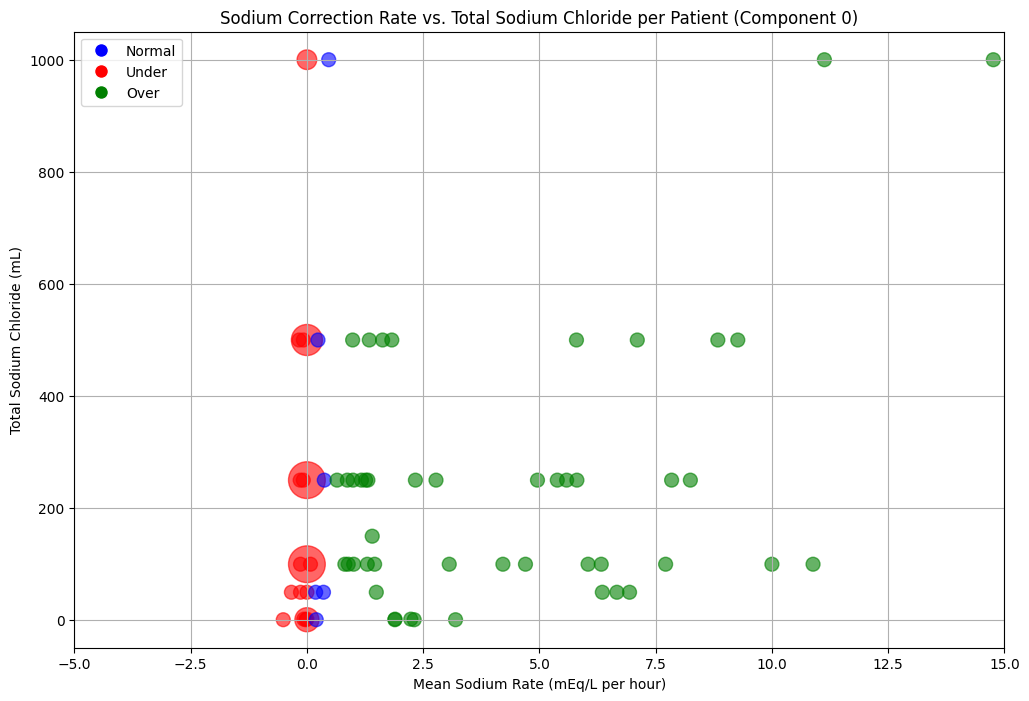

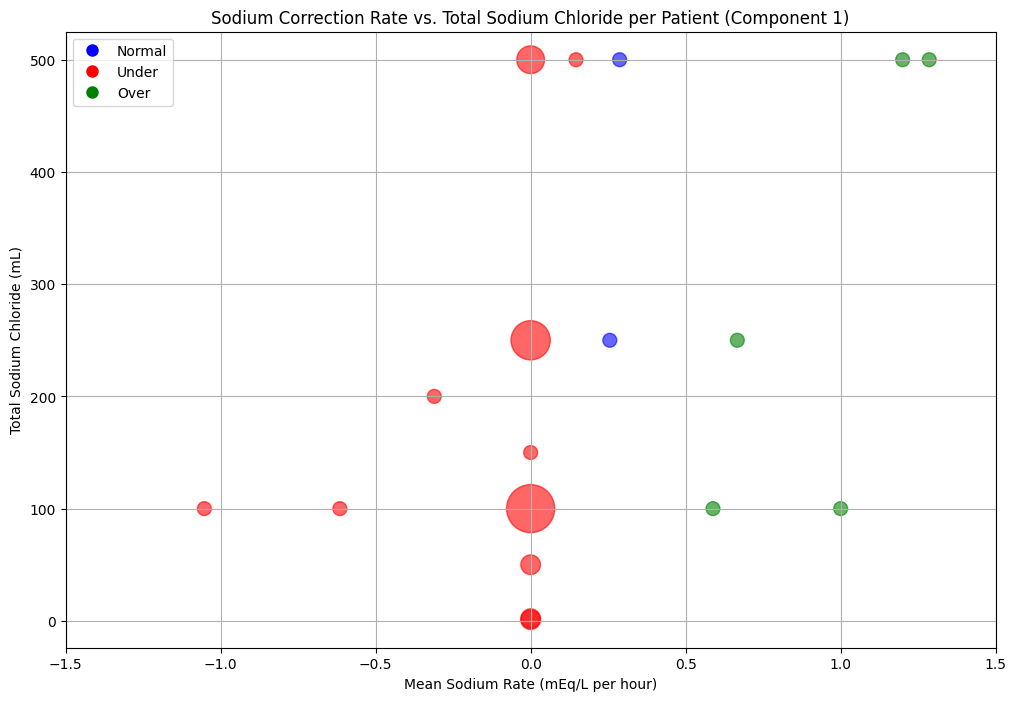

In [24]:
new_df['sodium_charttime'] = pd.to_datetime(new_df['sodium_charttime'])

# Sort the dataframe by subject_id, hadm_id, and sodium_charttime
new_df = new_df.sort_values(by=['subject_id', 'hadm_id', 'sodium_charttime'])

# Filter to keep only the first administration of sodium solution for each patient
first_sodium_admin = new_df[new_df['0.9% sodium chloride'] > 0].groupby(['subject_id', 'hadm_id']).first().reset_index()

# Extract the sodium_charttime of the first sodium administration
first_admin_times = first_sodium_admin[['subject_id', 'hadm_id', 'sodium_charttime']]

# Merge this information back to the original dataframe to get subsequent correction types
merged_df = pd.merge(new_df, first_admin_times, on=['subject_id', 'hadm_id'], suffixes=('', '_first_admin'))

# Filter to keep only records after the first sodium administration
post_first_admin = merged_df[merged_df['sodium_charttime'] > merged_df['sodium_charttime_first_admin']]

# Get the first correction type after the first sodium administration
first_correction_post_admin = post_first_admin.groupby(['subject_id', 'hadm_id']).first().reset_index()

# Calculate the mean sodium rate for each patient over the filtered period (first instances)
mean_sodium_rate_per_patient = first_correction_post_admin.groupby(['subject_id', 'hadm_id'])['sodium_rate'].mean().reset_index()

# Calculate the total 0.9% sodium chloride for each patient over the filtered period (first instances)
total_sodium_chloride_per_patient = first_sodium_admin.groupby(['subject_id', 'hadm_id'])['0.9% sodium chloride'].sum().reset_index()

# Merge the total sodium chloride and mean sodium rate back with the first_correction_post_admin to get the 'correction' column
patient_data = total_sodium_chloride_per_patient.merge(
    mean_sodium_rate_per_patient,
    on=['subject_id', 'hadm_id']
).merge(
    first_correction_post_admin[['subject_id', 'hadm_id', 'correction']].drop_duplicates(), 
    on=['subject_id', 'hadm_id'], 
    how='left'
)

# Rename columns for clarity
patient_data.rename(columns={'0.9% sodium chloride': 'total_sodium_chloride', 'sodium_rate': 'mean_sodium_rate'}, inplace=True)

# Merge the GMM labels with patient data
patient_data_with_labels = patient_data.merge(no_change_counts_df[['subject_id', 'hadm_id', 'gmm_label']], on=['subject_id', 'hadm_id'], how='left')

# Separate dataframes for each component
component_0_data = patient_data_with_labels[patient_data_with_labels['gmm_label'] == 0]
component_1_data = patient_data_with_labels[patient_data_with_labels['gmm_label'] == 1]

# Function to create the scatter plot with frequency
def plot_sodium_correction_rate_vs_total_sodium_chloride(component_data, component_label, xlim):
    # Count frequency of each unique pair (mean_sodium_rate, total_sodium_chloride)
    frequency = component_data.groupby(['mean_sodium_rate', 'total_sodium_chloride', 'correction']).size().reset_index(name='frequency')
    
    # Mapping of correction type to color
    color_map = {'normal': 'blue', 'under': 'red', 'over': 'green'}
    colors = frequency['correction'].map(color_map).tolist()
    
    plt.figure(figsize=(12, 8))
    plt.scatter(frequency['mean_sodium_rate'], frequency['total_sodium_chloride'], 
                s=frequency['frequency']*100,  # Scale the size of the points by frequency
                c=colors, alpha=0.6)
    plt.xlabel('Mean Sodium Rate (mEq/L per hour)')
    plt.ylabel('Total Sodium Chloride (mL)')
    plt.title(f'Sodium Correction Rate vs. Total Sodium Chloride per Patient (Component {component_label})')
    plt.xlim(xlim)  # Set the x-axis limit
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Normal'),
                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Under'),
                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Over')])
    plt.grid(True)
    plt.show()

# Create scatter plot for component 0
plot_sodium_correction_rate_vs_total_sodium_chloride(component_0_data, 0, xlim=(-5, 15))

# Create scatter plot for component 1
plot_sodium_correction_rate_vs_total_sodium_chloride(component_1_data, 1, xlim=(-1.5, 1.5))

/tmp/ipykernel_167315/4280027812.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='correction', y='0.9% sodium chloride', data=component_data, palette='viridis')


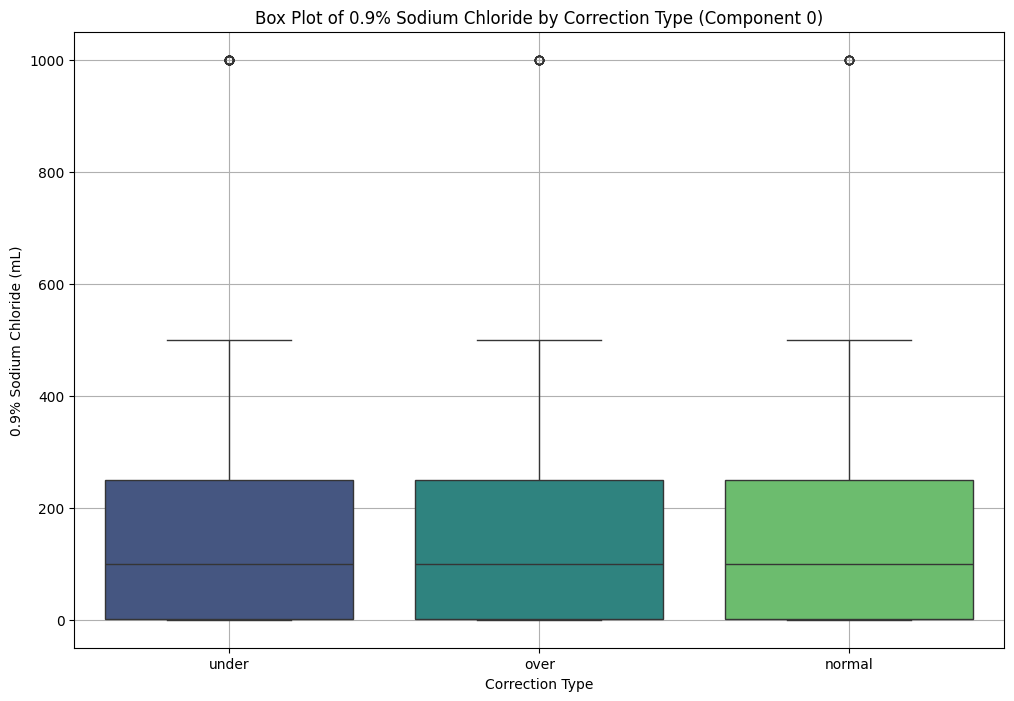

/tmp/ipykernel_167315/4280027812.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='correction', y='0.9% sodium chloride', data=component_data, palette='viridis')


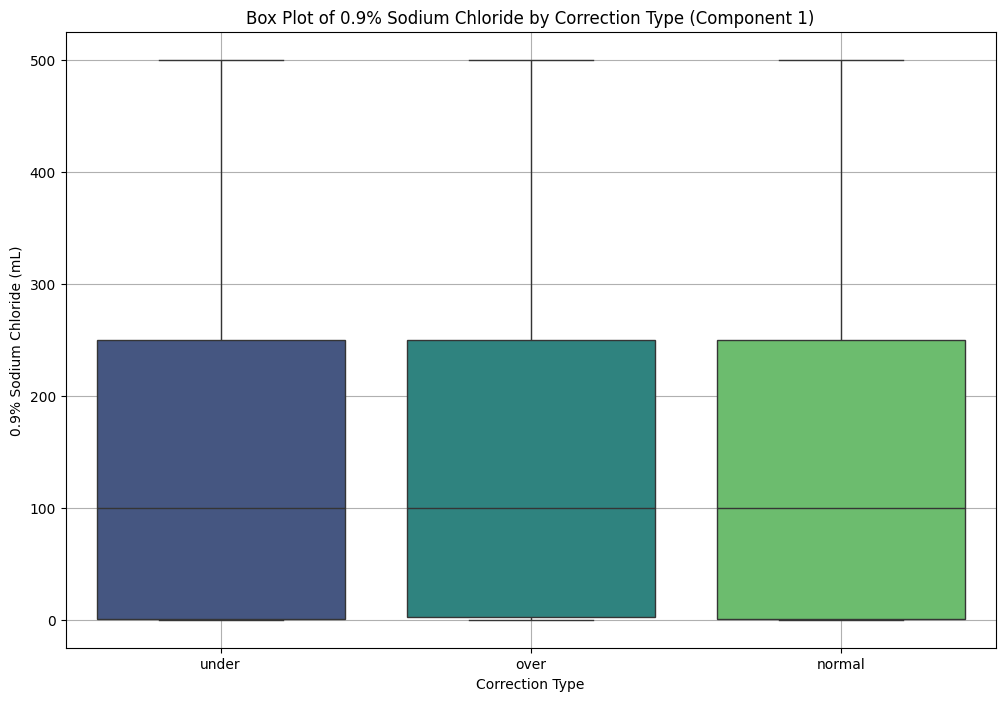

In [25]:
new_df['sodium_charttime'] = pd.to_datetime(new_df['sodium_charttime'])

# Sort the dataframe by subject_id, hadm_id, and sodium_charttime
new_df = new_df.sort_values(by=['subject_id', 'hadm_id', 'sodium_charttime'])

# Remove rows where sodium_rate is NaN (i.e., the first measurement for each patient)
new_df = new_df.dropna(subset=['sodium_rate'])

# Merge the GMM labels with the new_df
labeled_df = new_df.merge(no_change_counts_df[['subject_id', 'hadm_id', 'gmm_label']], on=['subject_id', 'hadm_id'], how='left')

# Separate dataframes for each component
component_0_df = labeled_df[labeled_df['gmm_label'] == 0]
component_1_df = labeled_df[labeled_df['gmm_label'] == 1]

# Function to create box plots
def create_box_plots(component_data, component_label):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='correction', y='0.9% sodium chloride', data=component_data, palette='viridis')
    plt.title(f'Box Plot of 0.9% Sodium Chloride by Correction Type (Component {component_label})')
    plt.xlabel('Correction Type')
    plt.ylabel('0.9% Sodium Chloride (mL)')
    plt.grid(True)
    plt.show()

# Create box plot for component 0
create_box_plots(component_0_df, 0)

# Create box plot for component 1
create_box_plots(component_1_df, 1)

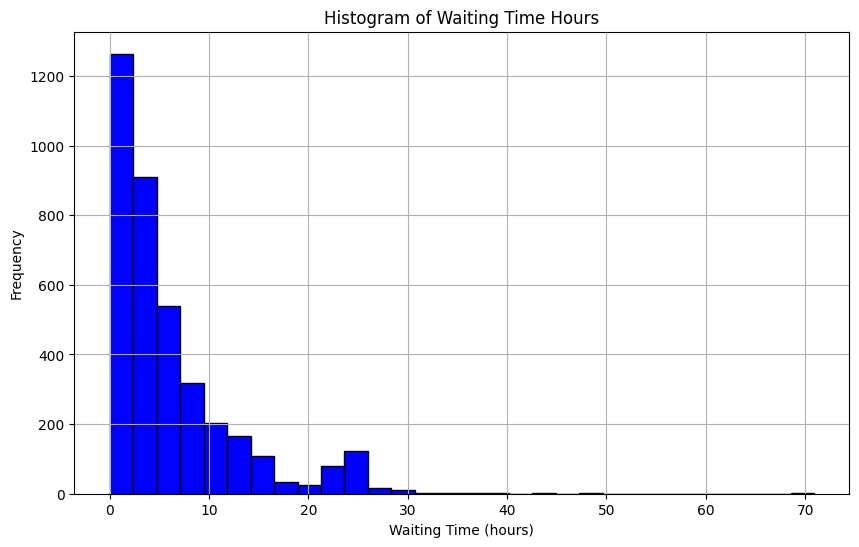

In [26]:
# Plot the histogram for the waiting_time_hours column
plt.figure(figsize=(10, 6))
plt.hist(data['waiting_time_hours'], bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Waiting Time Hours')
plt.xlabel('Waiting Time (hours)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [27]:
# Calculate the most common waiting time intervals, considering smaller intervals
common_intervals = data['waiting_time_hours'].value_counts().nlargest(10)

# Calculate the weighted average of the intervals
weighted_average = (common_intervals.index * common_intervals).sum() / common_intervals.sum()

print("Weighted average of the intervals:", weighted_average)

Weighted average of the intervals: 1.5076142131979695


In [28]:
new_df_with_labels['sodium_charttime'] = pd.to_datetime(new_df_with_labels['sodium_charttime'])

# Sort data
new_df_with_labels.sort_values(by=['subject_id', 'hadm_id', 'sodium_charttime'], inplace=True)

In [29]:
new_df_with_labels.columns

Index(['subject_id', 'hadm_id', 'sodium_charttime', 'Sodium', 'Potassium',
       'Chloride', 'Creatinine', 'Urea Nitrogen', 'Bicarbonate', 'Anion Gap',
       'Glucose', 'Magnesium', 'Hematocrit', 'Phosphate', 'Platelet Count',
       'Calcium, Total', 'Hemoglobin', 'White Blood Cells', 'MCHC', 'MCH',
       'Red Blood Cells', 'MCV', 'RDW', 'PTT', 'INR(PT)', 'PT', 'H', 'L', 'I',
       'RDW-SD', 'Bilirubin, Total', 'Alanine Aminotransferase (ALT)',
       'Asparate Aminotransferase (AST)', 'insulin', 'bag',
       'iso-osmotic dextrose', '0.9% sodium chloride',
       'sodium chloride 0.9%  flush', '5% dextrose', 'sterile water', 'sw',
       'furosemide', 'vial', 'desmopressin nasal', 'BMI (kg/m2)', 'age',
       'gender', 'Weight (kg)', 'Height (m)', 'waiting_time_hours',
       'sodium_rate', 'correction', 'sodium_no_change', 'gmm_label'],
      dtype='object')

In [30]:
# Define the number of lags
num_lags = 3
variables_to_lag = ['Sodium', 'Potassium', 'Chloride', 'Creatinine', 'Urea Nitrogen', 'Bicarbonate', 'Anion Gap',
       'Glucose', 'Magnesium', 'Hematocrit', 'Phosphate', 'Platelet Count',
       'Calcium, Total', 'Hemoglobin', 'White Blood Cells', 'MCHC', 'MCH',
       'Red Blood Cells', 'MCV', 'RDW', 'PTT', 'INR(PT)', 'PT', 'H', 'L', 'I',
       'RDW-SD', 'Bilirubin, Total', 'Alanine Aminotransferase (ALT)',
       'Asparate Aminotransferase (AST)', 'insulin', 'bag',
       'iso-osmotic dextrose', '0.9% sodium chloride',
       'sodium chloride 0.9%  flush', '5% dextrose', 'sterile water', 'sw',
       'furosemide', 'vial', 'desmopressin nasal']

# Create lagged features
for var in variables_to_lag:
    for lag in range(1, num_lags + 1):
        lag_column_name = f'{var}_lag_{lag}'
        new_df_with_labels[lag_column_name] = new_df_with_labels.groupby(['subject_id', 'hadm_id'])[var].shift(lag)

        # Apply linear interpolation to the lagged column within each group
        new_df_with_labels[lag_column_name] = new_df_with_labels.groupby(['subject_id', 'hadm_id'])[lag_column_name].transform(lambda x: x.interpolate(method='linear'))

/tmp/ipykernel_167315/386697213.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df_with_labels[lag_column_name] = new_df_with_labels.groupby(['subject_id', 'hadm_id'])[var].shift(lag)
/tmp/ipykernel_167315/386697213.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df_with_labels[lag_column_name] = new_df_with_labels.groupby(['subject_id', 'hadm_id'])[var].shift(lag)
/tmp/ipykernel_167315/386697213.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

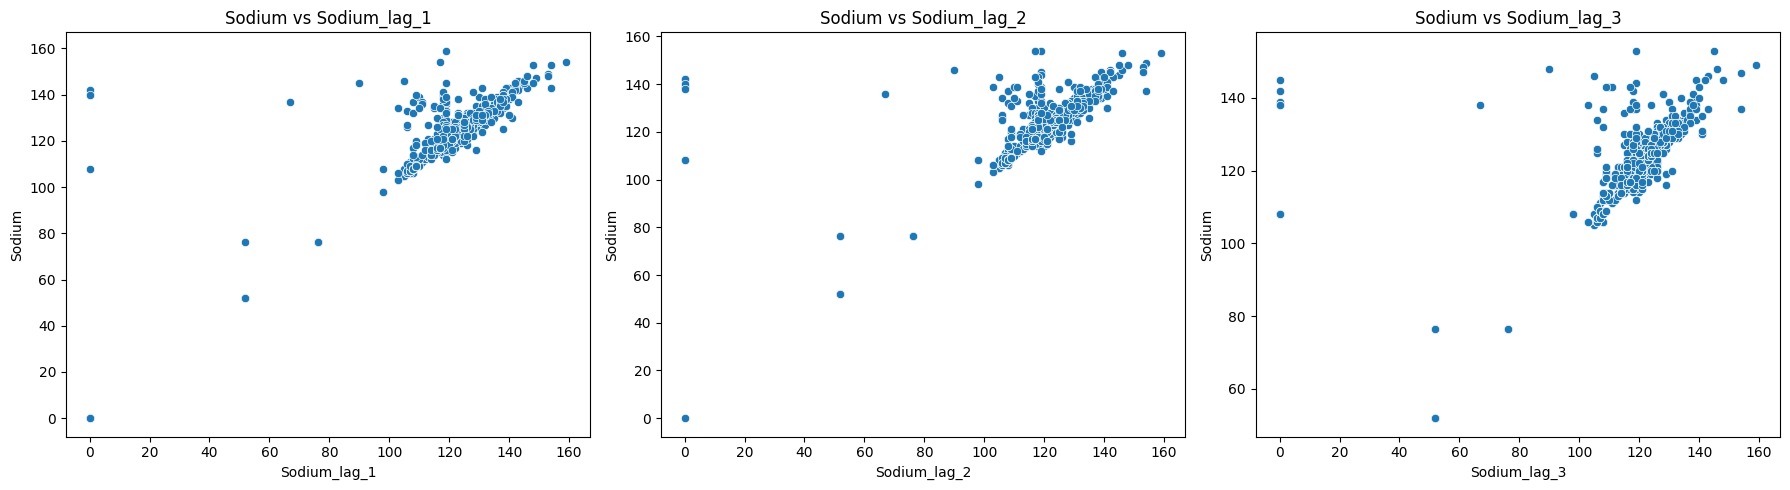

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Visualizing the relationship between Sodium and its lags
plt.figure(figsize=(18, 5))
for i, lag in enumerate(range(1, num_lags + 1)):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=f'Sodium_lag_{lag}', y='Sodium', data=new_df_with_labels)
    plt.title(f'Sodium vs Sodium_lag_{lag}')
    plt.xlabel(f'Sodium_lag_{lag}')
    plt.ylabel('Sodium')
plt.tight_layout()
plt.show()

In [32]:
print(new_df_with_labels.isnull().sum())

subject_id                    0
hadm_id                       0
sodium_charttime              0
Sodium                        0
Potassium                     0
                           ... 
vial_lag_2                  323
vial_lag_3                  483
desmopressin nasal_lag_1    162
desmopressin nasal_lag_2    323
desmopressin nasal_lag_3    483
Length: 177, dtype: int64


In [33]:
new_df_with_labels.dropna(inplace=True)

In [34]:
# Define additional features to use
additional_features = ['BMI (kg/m2)', 'age', 'gender', 'Weight (kg)', 'Height (m)', 'waiting_time_hours', 'gmm_label']

features = additional_features + [col for col in new_df_with_labels.columns if 'lag' in col]

features_1 = ['Sodium_lag_1']

# Remove 'Sodium_lag_1', 'Sodium_lag_2', and 'Sodium_lag_3' from the features list
features_2 = [feature for feature in features if feature not in ['Sodium_lag_1', 'Sodium_lag_2', 'Sodium_lag_3']]

# Keep identifiers and target for now
identifiers_and_target = new_df_with_labels[['sodium_charttime', 'subject_id', 'hadm_id', 'Sodium', 'waiting_time_hours','gmm_label']]

# Drop unnecessary columns except 'Sodium' for target variable
new_df_with_labels.drop(columns=['sodium_charttime', 'subject_id', 'hadm_id'], inplace=True)

# Initialize GroupShuffleSplit and prepare for the training and testing dataset
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
groups = identifiers_and_target['subject_id'].astype(str) + "_" + identifiers_and_target['hadm_id'].astype(str)

# Split data ensuring the same group is not in both training and testing
for train_idx, test_idx in gss.split(new_df_with_labels, groups=groups):
    train_data = new_df_with_labels.iloc[train_idx]
    test_data = new_df_with_labels.iloc[test_idx]

# Select features and target for training and testing
X_train = train_data[features]
y_train = train_data['Sodium']
X_test = test_data[features]
y_test = test_data['Sodium']

# Extracting test identifiers
test_identifiers = identifiers_and_target.iloc[test_idx]

# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, explained_variance_score

# Initialize results DataFrame
results = pd.DataFrame(columns=['Model', 'MSE', 'R2', 'MAE', 'MedAE', 'Explained Variance'])

# Define the models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'XGBoost': XGBRegressor(objective='reg:squarederror'),
    'Gradient Boosting': GradientBoostingRegressor(),
    'CatBoost': CatBoostRegressor(logging_level='Silent'),
    'Elastic Net': ElasticNet(),
    'LightGBM': LGBMRegressor(),
    'AdaBoost': AdaBoostRegressor(n_estimators=100)
}

# Iterate over the models, train, predict, and evaluate
for name, model in models.items():
    # Fit model
    model.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    explained_variance = explained_variance_score(y_test, y_pred)

    # Store results in a temporary DataFrame
    temp_results = pd.DataFrame({
    'Model': [name],
    'MSE': [mse],
    'R2': [r2],
    'MAE': [mae],
    'MedAE': [medae],
    'Explained Variance': [explained_variance]
    })

    # Concatenate results
    results = pd.concat([results, temp_results], ignore_index=True)

# Display results sorted by MSE in ascending order
print(results.sort_values(by='MSE', ascending=True))

/tmp/ipykernel_167315/2710332209.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, temp_results], ignore_index=True)
TBB Warning: The number of workers is currently limited to 39. The request for 223 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7943
[LightGBM] [Info] Number of data points in the train set: 1051, number of used features: 127
[LightGBM] [Info] Start training from score 120.896383
               Model        MSE        R2       MAE     MedAE  \
4           CatBoost   5.560688  0.894441  1.734090  1.362381   
6           LightGBM   9.951324  0.811094  1.668644  1.060591   
3  Gradient Boosting  12.934029  0.754473  1.747677  1.004401   
7           AdaBoost  14.180625  0.730809  2.450885  2.106049   
1      Random Forest  16.333334  0.689944  1.774298  0.920000   
2            XGBoost  20.021984  0.619922  1.864877  1.065063   
0  Linear Regression  40.373525  0.233588  2.186279  1.378384   
5        Elastic Net  48.094710  0.087017  5.312255  4.088914   

   Exp

In [36]:
from sklearn.model_selection import GridSearchCV

model = CatBoostRegressor()

param_grid = {
    'learning_rate': [0.1, 0.2],
    'depth': [2, 4],
    'l2_leaf_reg': [8 , 10],
    'iterations': [50, 100],
    #'bootstrap_type': ['Bernoulli', 'Bayesian'],
    #'grow_policy': ['Depthwise', 'Lossguide'],
    'leaf_estimation_method': ['Newton', 'Gradient'],
    'subsample': [0.7, 0.8]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', verbose=1)

# Fit GridSearchCV
grid.fit( X_train_scaled,y_train)

best_model = grid.best_estimator_
print(f"Best parameters found: {grid.best_params_}")
print(f"Best R2 score from GridSearch: {grid.best_score_}")

# Evaluate on the test set
y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse}")
print(f"Test R2: {r2}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
0:	learn: 10.8518320	total: 2.44ms	remaining: 119ms
1:	learn: 10.2313029	total: 3.75ms	remaining: 90ms
2:	learn: 9.6376926	total: 4.97ms	remaining: 77.9ms
3:	learn: 9.1254519	total: 6.28ms	remaining: 72.2ms
4:	learn: 8.7694192	total: 7.52ms	remaining: 67.7ms
5:	learn: 8.3488038	total: 8.74ms	remaining: 64.1ms
6:	learn: 7.9883327	total: 10ms	remaining: 61.4ms
7:	learn: 7.6513286	total: 11.3ms	remaining: 59.2ms
8:	learn: 7.2671584	total: 12.5ms	remaining: 57.1ms
9:	learn: 6.9178434	total: 13.7ms	remaining: 54.8ms
10:	learn: 6.6361173	total: 14.9ms	remaining: 52.8ms
11:	learn: 6.4030443	total: 16.1ms	remaining: 51ms
12:	learn: 6.1484043	total: 17.3ms	remaining: 49.3ms
13:	learn: 5.8934020	total: 18.6ms	remaining: 47.7ms
14:	learn: 5.6985772	total: 19.7ms	remaining: 46ms
15:	learn: 5.5047939	total: 20.9ms	remaining: 44.5ms
16:	learn: 5.2958056	total: 22.1ms	remaining: 42.9ms
17:	learn: 5.0678595	total: 23.3ms	remaining: 41.3ms
1

In [37]:
# Add predictions to the test identifiers DataFrame
test_identifiers['predicted_sodium'] = y_pred

# Sort chronologically 
test_identifiers.sort_values(by='sodium_charttime', inplace=True)

/tmp/ipykernel_167315/3869808930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_identifiers['predicted_sodium'] = y_pred
/tmp/ipykernel_167315/3869808930.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_identifiers.sort_values(by='sodium_charttime', inplace=True)


In [50]:
test_identifiers.tail(40)

sodium_charttime  subject_id   hadm_id  Sodium  waiting_time_hours  \
687  2184-03-23 16:54:00    13446881  29512879   117.0            0.200000   
688  2184-03-23 20:01:00    13446881  29512879   117.0            3.116667   
689  2184-03-23 22:02:00    13446881  29512879   117.0            2.016667   
690  2184-03-24 00:17:00    13446881  29512879   118.0            2.250000   
691  2184-03-24 00:42:00    13446881  29512879   118.0            0.416667   
692  2184-03-24 03:00:00    13446881  29512879   119.0            2.300000   
693  2184-03-24 04:21:00    13446881  29512879   119.0            1.350000   
694  2184-03-24 04:31:00    13446881  29512879   119.0            0.166667   
695  2184-03-24 10:39:00    13446881  29512879   119.0            6.133333   
696  2184-03-24 14:15:00    13446881  29512879   121.0            3.600000   
697  2184-03-24 17:19:00    13446881  29512879   117.0            3.066667   
698  2184-03-24 18:46:00    13446881  29512879   122.0            1.450000   
699  2184-03-24 19:44:00    13446881  29512879   122.0            0.966667   
700  2184-03-24 21:57:00    13446881  29512879   118.0            2.216667   
701  2184-03-25 01:04:00    13446881  29512879   125.0            3.116667   
220  2184-04-24 17:07:00    10939299  26422493   137.0            0.600000   
800  2184-10-20 07:41:00    14382048  27648995   134.0           24.600000   
355  2185-05-10 12:20:00    11818034  22420026   117.0            5.516667   
356  2185-05-10 17:28:00    11818034  22420026   119.0            5.133333   
357  2185-05-10 19:29:00    11818034  22420026   116.0            2.016667   
358  2185-05-10 20:53:00    11818034  22420026   115.0            1.400000   
359  2185-05-10 22:25:00    11818034  22420026   115.0            1.533333   
360  2185-05-11 02:20:00    11818034  22420026   120.0            3.916667   
361  2185-05-11 07:43:00    11818034  22420026   127.0            5.383333   
362  2185-05-11 12:04:00    11818034  22420026   130.0            4.350000   
363  2185-05-11 12:49:00    11818034  22420026   130.0            0.750000   
364  2185-05-11 15:30:00    11818034  22420026   129.0            2.683333   
365  2185-05-11 20:43:00    11818034  22420026   128.0            5.216667   
366  2185-05-12 00:21:00    11818034  22420026   131.0            3.633333   
1153 2186-01-23 23:42:00    16721869  22971398   118.0            3.933333   
1154 2186-01-24 03:41:00    16721869  22971398   118.0            3.983333   
1155 2186-01-24 08:15:00    16721869  22971398   118.0            4.566667   
1156 2186-01-24 16:45:00    16721869  22971398   118.0            8.500000   
1157 2186-01-24 21:39:00    16721869  22971398   116.0            4.900000   
1158 2186-01-25 02:49:00    16721869  22971398   116.0            5.166667   
1786 2192-04-29 03:03:00    19651093  26488509   138.0            3.866667   
1787 2192-04-29 18:53:00    19651093  26488509   137.0           15.833333   
1788 2192-04-30 04:04:00    19651093  26488509   138.0            9.183333   
780  2195-03-10 05:37:00    13979643  25507998   143.0           24.066667   
245  2199-10-27 05:13:00    11204646  29675270   118.0           12.783333   

      gmm_label  predicted_sodium time_bin  
687           1        117.948660      0-5  
688           1        118.064308      0-5  
689           1        117.987388      0-5  
690           1        117.987388      0-5  
691           1        118.865698      0-5  
692           1        119.003517      0-5  
693           1        119.166792      0-5  
694           1        119.370690      0-5  
695           1        119.631257     5-10  
696           1        119.631257      0-5  
697           1        120.692360      0-5  
698           1        118.808629      0-5  
699           1        121.149637      0-5  
700           1        121.992853      0-5  
701           1        120.305871      0-5  
220           0        128.172294      0-5  
800           0        132.136088    20-30  

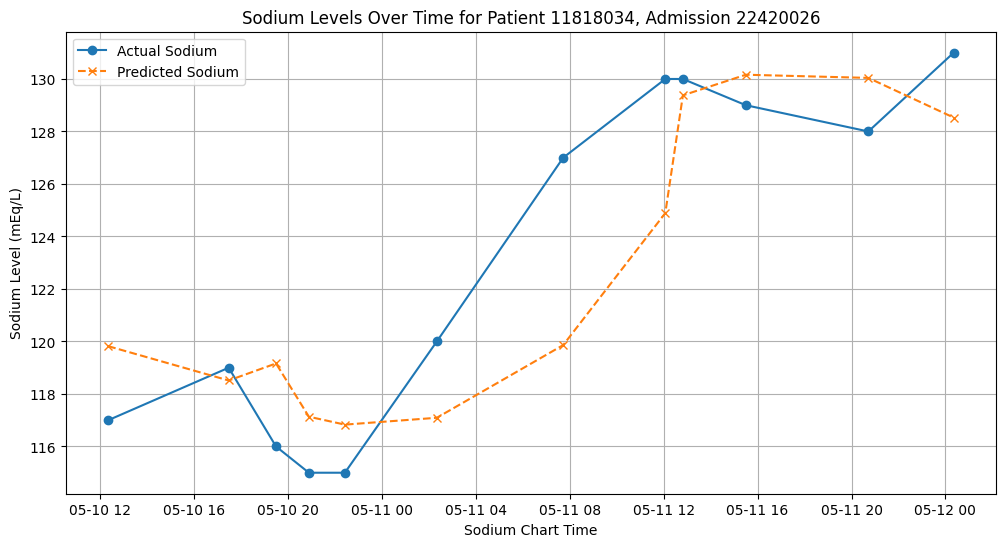

In [51]:
import matplotlib.pyplot as plt
	
#specific_subject_id = 19612211
#specific_hadm_id = 29358010

specific_subject_id = 11818034		
specific_hadm_id = 22420026

#specific_subject_id = 15112354
#specific_hadm_id = 29551743

patient_data = test_identifiers[(test_identifiers['subject_id'] == specific_subject_id) & (test_identifiers['hadm_id'] == specific_hadm_id)]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(patient_data['sodium_charttime'], patient_data['Sodium'], label='Actual Sodium', marker='o', linestyle='-')
plt.plot(patient_data['sodium_charttime'], patient_data['predicted_sodium'], label='Predicted Sodium', marker='x', linestyle='--')
plt.title(f'Sodium Levels Over Time for Patient {specific_subject_id}, Admission {specific_hadm_id}')
plt.xlabel('Sodium Chart Time')
plt.ylabel('Sodium Level (mEq/L)')
plt.legend()
plt.grid(True)
plt.show()

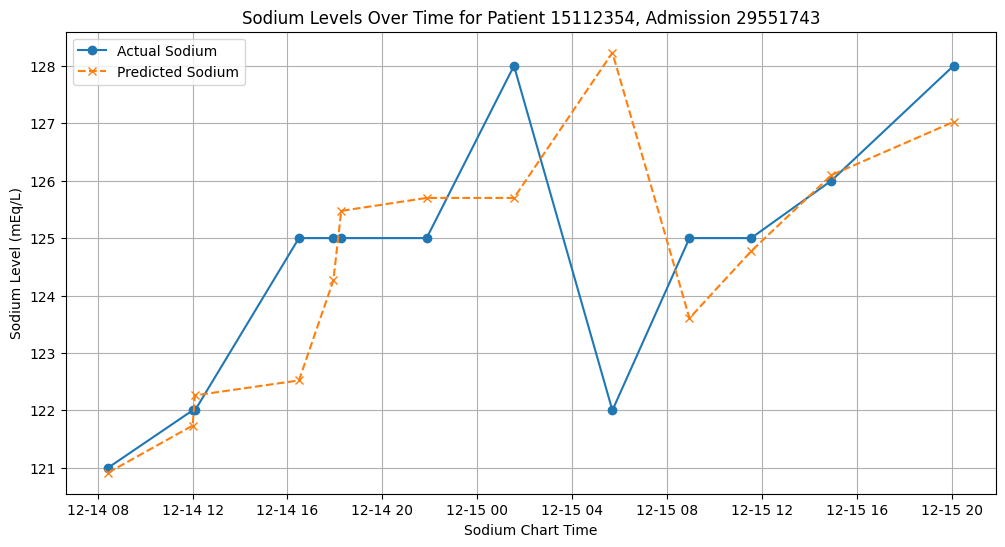

In [40]:
specific_subject_id = 	15112354	
specific_hadm_id = 29551743

patient_data = test_identifiers[(test_identifiers['subject_id'] == specific_subject_id) & (test_identifiers['hadm_id'] == specific_hadm_id)]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(patient_data['sodium_charttime'], patient_data['Sodium'], label='Actual Sodium', marker='o', linestyle='-')
plt.plot(patient_data['sodium_charttime'], patient_data['predicted_sodium'], label='Predicted Sodium', marker='x', linestyle='--')
plt.title(f'Sodium Levels Over Time for Patient {specific_subject_id}, Admission {specific_hadm_id}')
plt.xlabel('Sodium Chart Time')
plt.ylabel('Sodium Level (mEq/L)')
plt.legend()
plt.grid(True)
plt.show()

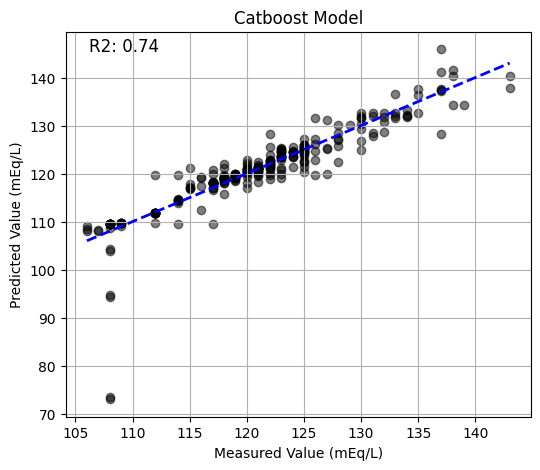

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='black')  
plt.xlabel('Measured Value (mEq/L)')
plt.ylabel('Predicted Value (mEq/L)')
plt.title('Catboost Model')

# Add a line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'blue', lw=2, linestyle='--')

# Display R2 value on the plot
plt.text(x=0.05, y=0.95, s=f"R2: {r2:.2f}", fontsize=12, transform=plt.gca().transAxes)

plt.grid(True)
plt.show()

In [42]:
feature_importances = best_model.get_feature_importance()
features = X_train.columns  

# Create a DataFrame to view feature importances
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort features by importance
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

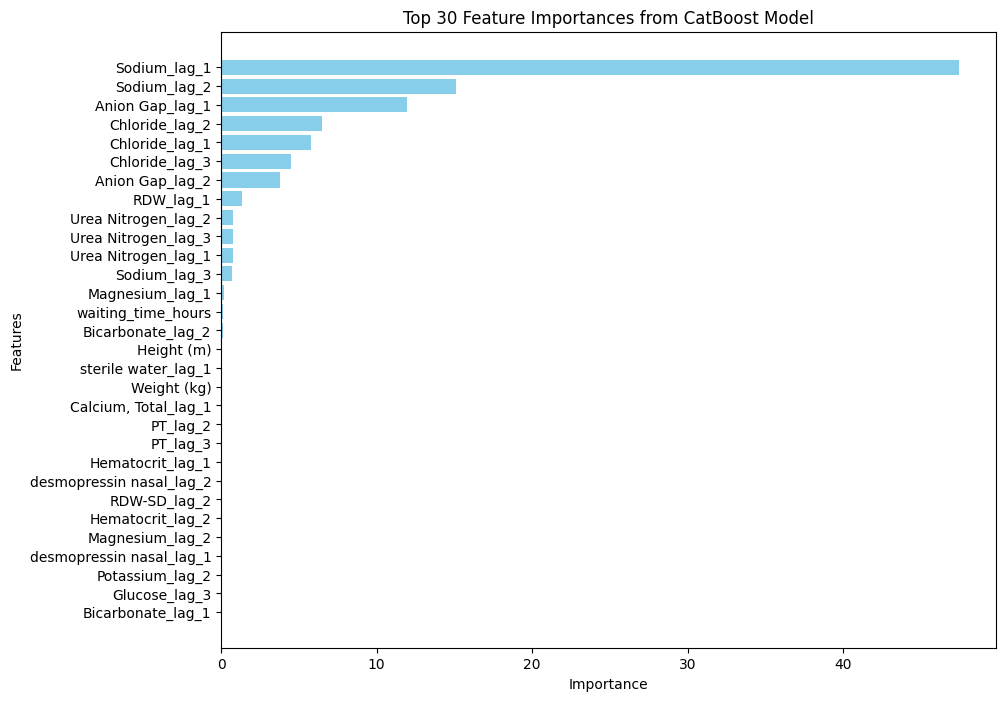

In [43]:
top_30_features = importances_df.head(30)

# Plotting feature importances for the top 30 features
plt.figure(figsize=(10, 8))
plt.barh(top_30_features['Feature'], top_30_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 30 Feature Importances from CatBoost Model')
plt.gca().invert_yaxis()  
plt.show()

In [44]:
min_waiting_time = data['waiting_time_hours'].min()
max_waiting_time = data['waiting_time_hours'].max()

print(f"Minimum waiting time (hours): {min_waiting_time}")
print(f"Maximum waiting time (hours): {max_waiting_time}")

Minimum waiting time (hours): 0.0
Maximum waiting time (hours): 70.9


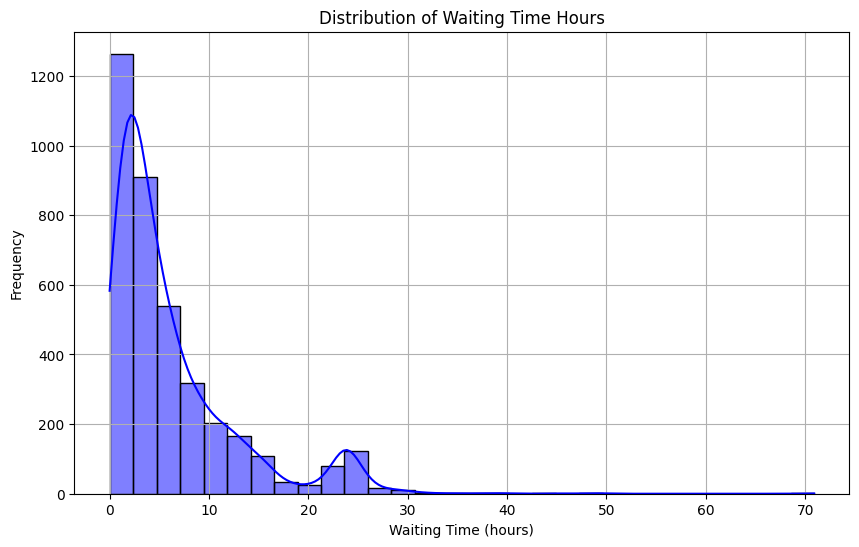

In [45]:
# Plotting the distribution of waiting_time_hours
plt.figure(figsize=(10, 6))
sns.histplot(data['waiting_time_hours'], bins=30, kde=True, color='blue')  # KDE plot overlays a density curve
plt.title('Distribution of Waiting Time Hours')
plt.xlabel('Waiting Time (hours)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [46]:
bins = [0, 5, 10, 20, 30, np.inf]
labels = ['0-5', '5-10', '10-20', '20-30', '30+']

test_identifiers['time_bin'] = pd.cut(test_identifiers['waiting_time_hours'], bins=bins, labels=labels, right=False)

/tmp/ipykernel_167315/1682685603.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_identifiers['time_bin'] = pd.cut(test_identifiers['waiting_time_hours'], bins=bins, labels=labels, right=False)


In [47]:
bin_grouped = test_identifiers.groupby('time_bin', observed=True)  # Set observed=True to consider only non-empty groups
r2_scores_by_bin = {}

for name, group in bin_grouped:
    if not group.empty:  # Check if the group is not empty
        actual_values = group['Sodium']
        predicted_values = group['predicted_sodium']
        r2_score_bin = r2_score(actual_values, predicted_values)
        r2_scores_by_bin[name] = r2_score_bin
    else:
        r2_scores_by_bin[name] = None  # Assign None or a similar indicator for empty bins

for bin_range, r2 in r2_scores_by_bin.items():
    if r2 is not None:
        print(f"R2 score for bin {bin_range}: {r2:.2f}")
    else:
        print(f"R2 score for bin {bin_range}: No Data")

R2 score for bin 0-5: 0.67
R2 score for bin 5-10: 0.80
R2 score for bin 10-20: 0.75
R2 score for bin 20-30: 0.54


In [48]:
test_identifiers

sodium_charttime  subject_id   hadm_id  Sodium  waiting_time_hours  \
984  2114-01-03 16:03:00    15248866  28736378   108.0            0.733333   
985  2114-01-03 17:07:00    15248866  28736378   117.0            1.066667   
986  2114-01-03 19:00:00    15248866  28736378   117.0            1.883333   
987  2114-01-03 19:23:00    15248866  28736378   117.0            0.383333   
988  2114-01-03 21:28:00    15248866  28736378   117.0            2.083333   
...                  ...         ...       ...     ...                 ...   
1786 2192-04-29 03:03:00    19651093  26488509   138.0            3.866667   
1787 2192-04-29 18:53:00    19651093  26488509   137.0           15.833333   
1788 2192-04-30 04:04:00    19651093  26488509   138.0            9.183333   
780  2195-03-10 05:37:00    13979643  25507998   143.0           24.066667   
245  2199-10-27 05:13:00    11204646  29675270   118.0           12.783333   

      gmm_label  predicted_sodium time_bin  
984           1        109.592177      0-5  
985           1        109.514231      0-5  
986           1        116.577078      0-5  
987           1        117.963108      0-5  
988           1        118.191866      0-5  
...         ...               ...      ...  
1786          0        141.658801      0-5  
1787          0        141.183373    10-20  
1788          0        140.350950     5-10  
780           0        137.851034    20-30  
245           0        121.108058    10-20  

[299 rows x 8 columns]

In [49]:
data_label_0 = test_identifiers[test_identifiers['gmm_label'] == 0]
r2_label_0 = r2_score(data_label_0['Sodium'], data_label_0['predicted_sodium'])
data_label_1 = test_identifiers[test_identifiers['gmm_label'] == 1]
r2_label_1 = r2_score(data_label_1['Sodium'], data_label_1['predicted_sodium'])

print(f'R² score for gmm_label 0: {r2_label_0}')
print(f'R² score for gmm_label 1: {r2_label_1}')

R² score for gmm_label 0: 0.8095436481952047
R² score for gmm_label 1: 0.6615933158630474
